In [179]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import make_interp_spline
from scipy.stats import ttest_ind, ks_2samp
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# %matploblib inline

In [2]:
xr.set_options(display_style='text')ks_2samp

In [3]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/'
# # statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'
# # sat_file = f'{statsdir}/stats_goes16_dilated_20181015.0000_20190303.0000.nc'
# sat_file = f'{statsdir}/stats_goes16_undilated_20181015.0000_20190303.0000.nc'
# sonde_file = f'{statsdir}/interpsonde_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284
radar_alt = 1.141  # radar altitude ASL [km]

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats/celltrack_environment_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats_mpgrid/celltrack_environment_stats/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/


In [4]:
# terr = xr.open_dataset(terrain_file)
# topoZ = terr['z']
# topoLon = terr['x']
# topoLat = terr['y']
# # topoZ = terr.hgt
# # topoLon = terr.longitude
# # topoLat = terr.latitude

# topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [5]:
def get_layer_boundary(idx, gap, min_thick):
    """
    Get contiguous layer boundary indices.
    ----------
    idx: np.array(int)
        Indices of points.
    gap: int
        If a gap larger than this exists, they are separated into different layers
    min_thick: int
        Minimum thickness of a layer.

    Returns
    ----------
    layer_start: np.ndarray(nLayers)
        Start index for each layer.
    layer_end: np.ndarray(nLayers)
        End index for each layer.
    """

    # Split idx into layers
    Layers = np.split(idx, np.where(np.diff(idx) > gap)[0]+1)
    nLayers = len(Layers)

    # Create layer_start, layer_end arrays
    layer_start = np.full(nLayers, -99, dtype=int)
    layer_end = np.full(nLayers, -99, dtype=int)

    if nLayers > 0:
        # Loop over each layer
        for iLayer in range(0, nLayers):

            # Calculate layer thickness
            zb = Layers[iLayer][0]
            zt = Layers[iLayer][-1]
            dz = zt - zb
            # A layer must be thicker than min_thick here:
            if (dz > min_thick):
                layer_start[iLayer] = zb
                layer_end[iLayer] = zt
        
        # Exclude negative (i.e., thickness <= min_thick)
        layer_start = layer_start[layer_start >= 0]
        layer_end = layer_end[layer_end >= 0]

    return layer_start, layer_end

def get_growth_rate1(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    Y_s = signal.filtfilt(b, a, Y_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_s) / np.diff(X_)
    
    return (X_, Y_, Y_s, dY)

def get_growth_rate2(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)
    
    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    y_s = signal.filtfilt(b, a, y)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y_s)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_) / np.diff(X_)
    
    return (X_, Y_, y_s, dY)

def define_growth_stage(X, dY, min_rate_percent, gap=1, min_dur=0):
    
    growth_flag = np.zeros(len(dY), dtype=int)
    
    # Get the percentile for positive area change rate
    # dY_thres = np.quantile(dY[dY > 0], min_rate_percent)
    
    # Get the percentile for absolute area change rate
    dY_thres = np.quantile(np.abs(dY), min_rate_percent)
    
    # Get positive dY indices
    idx_p = np.where(dY > dY_thres)[0]
    # Get negative dY indices
    idx_n = np.where(dY < dY_thres)[0]
    
    # Proceed if there is sufficient sample to define layers
    if (len(idx_p) > min_dur) & (len(idx_n) > min_dur):
        # Get growth period indices
        gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_dur)
        g_dur = gidx_e - gidx_s    
        # Get decay period indices
        didx_s, didx_e = get_layer_boundary(idx_n, gap, min_dur)
        d_dur = didx_e - didx_s

        # print('Growth:', gidx_s)
        # print('Decay:', didx_s)
        # Combine growth and decayse period start/end indices, and sort them
        idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
        idx_e = np.sort(np.concatenate((gidx_e, didx_e)))
        # print('Combine:', idx_s)
        # Find growth indices in the combine index array
        junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
        junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
        # print('Match growth index:', g1)
        # print('Match decay index:', d1)
        # Set growth period to 1, decay period to -1
        stages = np.zeros(len(idx_s), dtype=int)
        stages[g1] = 1
        stages[d1] = -1
        # print('Stages:', stages)

        # Proceed if first stage is growth
        if stages[0] == 1:
            # Set periods of first stage to 1
            growth_flag[idx_s[0]:idx_e[0]] = 1

            # Compute stage differences
            stage_diff = np.diff(stages)
            # print(stage_diff)
            # Find indices of consecutive growth/decay stages (diff==0)
            idx_consec = np.where(stage_diff == 0)[0]
            if len(idx_consec) > 0:
                # Loop over each consecutive stage
                for p in range(len(idx_consec)):
                    idxp = idx_consec[p]
                    # For the first stage
                    if idxp == 0:
                        # If it is a growth stage, set the next stage flag as growth
                        if stages[idxp] == 1:
                            growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1
                    # For subsequent stages
                    else:
                        # If both previous and current stage are growth, 
                        # set the next stage flag as growth
                        if (stages[idxp-1] == 1) & (stages[idxp] == 1):
                            growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1
    
    return growth_flag, dY_thres

In [6]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [7]:
# Read 2D track data
stats = xr.open_dataset(stats_file)
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']
stats.dims['tracks']

6895

In [8]:
# Read 3D data
stats3d = xr.open_dataset(stats_file3d)
stats3d.dims['tracks']

6895

In [9]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [10]:
# Combine 2D and 3D datasets by coordinates
stats = xr.combine_by_coords([stats, stats3d, sonde], combine_attrs='override')
stats.load()

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895, z: 45)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
  * z                            (z) float64 0.0 500.0 ... 2.15e+04 2.2e+04
Data variables: (12/296)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    max_zdr                      (tracks, times, z) float32 6.446 6.446 ... nan
    max_kdp                      (tracks, times, z) float32 0.0 0.0 ... nan nan
    max_rainrate                 (tracks, times, z) float32 0.0 0.0 ... nan nan
    max_Dm                       (tracks, times, z) float32 3.687 3.687 ... nan
    max_lwc                      (tracks, times, z) float32 0.0 0.0 ... nan nan
    volrain                      (tracks, times, z) float32 0.0 0.0 ... nan nan
Attributes:
    title:              InterpSonde parameters matched to tracked cells
    Institution:        Pacific Northwest National Laboratoy
    Contact:            Zhe Feng, zhe.feng@pnnl.gov
    Created_on:         Tue Nov 23 16:20:27 2021
    source_track_file:  /global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/t...
    source_sonde_file:  /global/cfs/cdirs/m1657/zfeng/cacti/arm/csapr/taranis...
    startdate:          20181015.0000
    enddate:            20190303.0000

In [11]:
tracks = stats['tracks']
times = stats['times']
height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [12]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [13]:
# cape = stats.cape.sel(reltime=0)
# cape = cape.where(cape > 0)
# cape.plot.hist(bins=50)

In [14]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [15]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [16]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [17]:
# Choose 0 hour relative time, and filter negative parcel values
cape = stats['CAPE_mu'].where(stats['CAPE_mu'] > 0).sel(reltime=0)
cin = stats['CIN_IB_mu'].where(stats['CIN_IB_mu'] >= 0).sel(reltime=0)
lcl_z = stats['LCL_height_mu'].where(stats['LCL_height_mu'] >= 0).sel(reltime=0) / 1000
lfc_z = stats['LFC_height_mu'].where(stats['LFC_height_mu'] >= 0).sel(reltime=0) / 1000
lnb_z = stats['EL_height_mu'].where(stats['EL_height_mu'] >= 0).sel(reltime=0) / 1000
lpl_z = stats['initial_ht_parcel_mu'].where(stats['initial_ht_parcel_mu'] >= 0).sel(reltime=0) / 1000
q850p = stats['rvap_850mb'].sel(reltime=0)
q700p = stats['rvap_700mb'].sel(reltime=0)
rh700p = stats['rh_700mb'].sel(reltime=0)
rh500p = stats['rh_500mb'].sel(reltime=0)
shear6mag = stats['shear_mag_bulk_0to6km'].sel(reltime=0)
shear3mag = stats['shear_mag_bulk_0to3km'].sel(reltime=0)
u700p = stats['U_700mb'].sel(reltime=0)
v700p = stats['V_700mb'].sel(reltime=0)
u850p = stats['U_850mb'].sel(reltime=0)
v850p = stats['V_850mb'].sel(reltime=0)

In [18]:
# ibin = 19
# icape = cape.where((max_eth30 >= eth_bins[ibin]) & (max_eth30 < eth_bins[ibin+1]), drop=True)
# icape.sizes['tracks']

In [19]:
# Get max value over lifetime
max_eth30 = eth30.max(dim='times')
max_dbz = stats.maxdbz.max(dim='times')

eth_bins = np.arange(0,20.1,1)
# dbz_bins = np.arange(10,75.1,5)
dbz_bins = np.arange(10,70.1,5)
quantiles_2Dvar = [0.25,0.5,0.75]

max_dbz_ns, bins = np.histogram(max_dbz, bins=dbz_bins, density=False)
max_eth30_ns, bins = np.histogram(max_eth30, bins=eth_bins, density=False)

nquantiles = len(quantiles_2Dvar)
maxETH30_cape_pts = np.full((len(eth_bins)-1, nquantiles), np.nan, dtype=float)
maxdbz_cape_pts = np.full((len(dbz_bins)-1, nquantiles), np.nan, dtype=float)

min_nsample = 5
maxETH30_cape_avg = np.full(len(eth_bins)-1, np.nan, dtype=float)
maxdbz_cape_avg = np.full(len(dbz_bins)-1, np.nan, dtype=float)
for ibin in range(len(eth_bins)-1):
    icape = cape.where((max_eth30 >= eth_bins[ibin]) & (max_eth30 < eth_bins[ibin+1]), drop=True)
    if (icape.sizes['tracks'] > min_nsample):
        maxETH30_cape_pts[ibin,:] = icape.quantile(quantiles_2Dvar, skipna=True)
        maxETH30_cape_avg[ibin] = icape.mean()

for ibin in range(len(dbz_bins)-1):
    icape = cape.where((max_dbz >= dbz_bins[ibin]) & (max_dbz < dbz_bins[ibin+1]), drop=True)
    if (icape.sizes['tracks'] > min_nsample):
        maxdbz_cape_pts[ibin,:] = icape.quantile(quantiles_2Dvar, skipna=True)
        maxdbz_cape_avg[ibin] = icape.mean()
    
# plt.plot(eth_bins[:-1], cape_eth30)

In [20]:
cape_bins = np.arange(0,4001,200)

cape_ns, bins = np.histogram(cape, bins=cape_bins, density=False)

cape_maxETH30_pts = np.full((len(cape_bins)-1, nquantiles), np.nan, dtype=float)

cape_maxETH30_avg = np.full(len(cape_bins)-1, np.nan, dtype=float)
for ibin in range(len(cape_bins)-1):
    cape_maxETH30_pts[ibin,:] = max_eth30.where((cape >= cape_bins[ibin]) & (cape < cape_bins[ibin+1]), drop=True).quantile(quantiles_2Dvar, skipna=True)
    cape_maxETH30_avg[ibin] = max_eth30.where((cape >= cape_bins[ibin]) & (cape < cape_bins[ibin+1]), drop=True).mean()

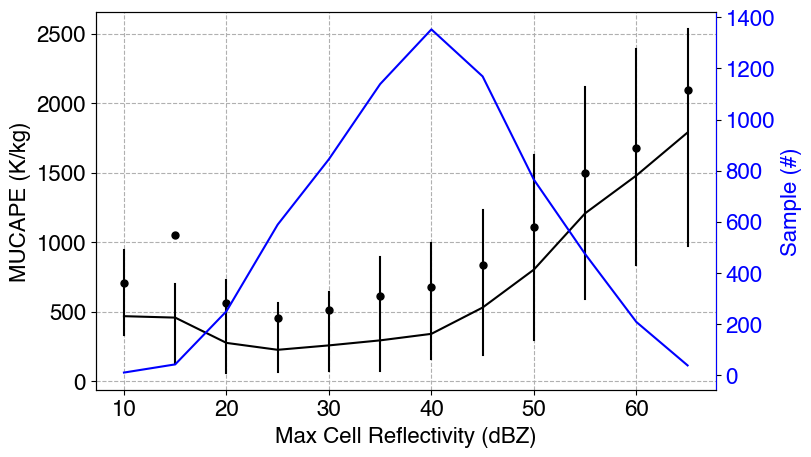

In [21]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
ax1.plot(dbz_bins[:-1], maxdbz_cape_pts[:,1], color='k')
for ibin in range(len(dbz_bins)-1):
    ax1.plot((dbz_bins[ibin],dbz_bins[ibin]), maxdbz_cape_pts[ibin,(0,2)], color='k')
ax1.plot(dbz_bins[:-1], maxdbz_cape_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('Max Cell Reflectivity (dBZ)')
ax1.set_ylabel('MUCAPE (K/kg)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(dbz_bins[:-1], max_dbz_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
# ax2.set_ylim(4, 18)
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

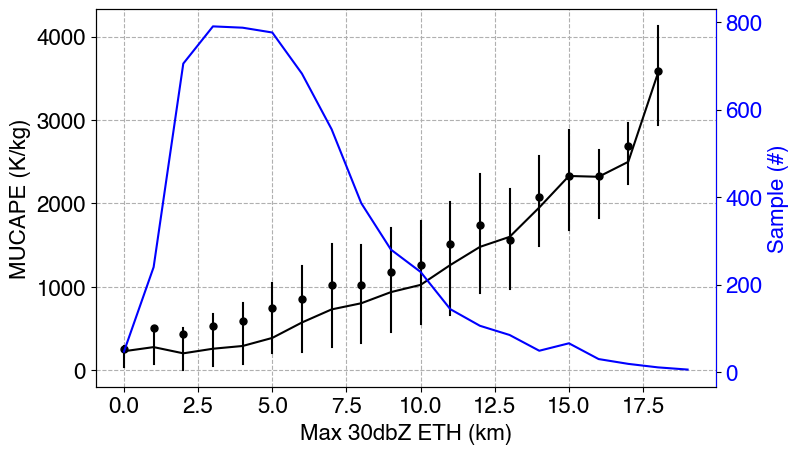

In [22]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
# ax1.errorbar(eth_bins[:-1], maxETH30_cape_pts[:,1], yerr=maxETH30_cape_pts[:,(0,2)].transpose(), color='k')
ax1.plot(eth_bins[:-1], maxETH30_cape_pts[:,1], color='k')
for ibin in range(len(eth_bins)-1):
    ax1.plot((eth_bins[ibin],eth_bins[ibin]), maxETH30_cape_pts[ibin,(0,2)], color='k')
ax1.plot(eth_bins[:-1], maxETH30_cape_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('Max 30dbZ ETH (km)')
ax1.set_ylabel('MUCAPE (K/kg)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(eth_bins[:-1], max_eth30_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
# ax2.set_ylim(4, 18)
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

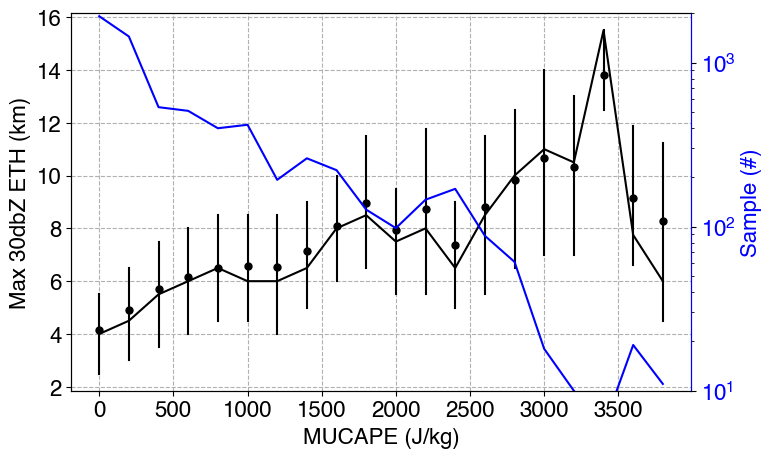

In [23]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
ax1.plot(cape_bins[:-1], cape_maxETH30_pts[:,1], color='k')
for ibin in range(len(cape_bins)-1):
    ax1.plot((cape_bins[ibin],cape_bins[ibin]), cape_maxETH30_pts[ibin,(0,2)], color='k')
ax1.plot(cape_bins[:-1], cape_maxETH30_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('MUCAPE (J/kg)')
ax1.set_ylabel('Max 30dbZ ETH (km)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(cape_bins[:-1], cape_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
ax2.set_ylim(10, 2000)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

In [24]:
# Find tracks initiation east of SDC during the day (12PM - 8PM)
# LT = UTC + 3
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
# lon_eSDC = [-64.9, -63.]
lon_SDC = -65
lon_eSDC = [-65, -63]
# Day/night hour range in UTC
UTChour_day = [15,22]
UTChour_night = [0,8]

# cape_range1 = [50,500]
# cape_range2 = [500,1500]
# cape_range3 = [1500,4000]
cape_range1 = [50,400]
cape_range2 = [400,900]
cape_range3 = [900,4000]

cell_area1_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
cell_area2_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range2[0]) & (cape <= cape_range2[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
cell_area3_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range3[0]) & (cape <= cape_range3[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
ntracks1_cape = cell_area1_cape.sizes['tracks']
ntracks2_cape = cell_area2_cape.sizes['tracks']
ntracks3_cape = cell_area3_cape.sizes['tracks']
print(f'Number of tracks: {ntracks1_cape}, {ntracks2_cape}, {ntracks3_cape}')

# max_dbz1_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                              (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)

Number of tracks: 1033, 534, 665


(array([0.5812987 , 1.29177488, 1.09800865, 0.82350649, 0.59744588,
        0.4601951 , 0.27450199, 0.11303037, 0.10495664, 0.02422079]),
 array([1.1383027, 1.3245592, 1.5108157, 1.6970723, 1.8833288, 2.0695853,
        2.2558417, 2.4420984, 2.6283548, 2.8146114, 3.0008678],
       dtype=float32),
 <BarContainer object of 10 artists>)

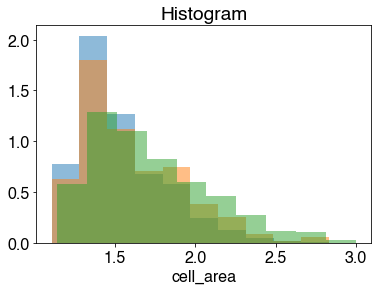

In [25]:
np.log10(cell_area1_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)
np.log10(cell_area2_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)
np.log10(cell_area3_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)

In [26]:
# cell_area1_capeshear6mag = stats.cell_area.where((start_lon >= lon_eSDC[0]) & (start_lon <= lon_eSDC[1]) &
#                                                  (cape > cape_range1[0]) & (cape <= cape_range1[1]) & 
#                                                  (shear6mag > shear6mag_range1[0]) & (shear6mag <= shear6mag_range2[1]) &
#                                                  (np.isnan(end_merge_tracknumber)) & (np.isnan(start_split_tracknumber)), drop=True)
# cell_area2_capeshear6mag = stats.cell_area.where((start_lon >= lon_eSDC[0]) & (start_lon <= lon_eSDC[1]) &
#                                                  (cape > cape_range2[0]) & (cape <= cape_range2[1]) & 
#                                                  (shear6mag > shear6mag_range2[0]) & (shear6mag <= shear6mag_range2[1]) &
#                                                  (np.isnan(end_merge_tracknumber)) & (np.isnan(start_split_tracknumber)), drop=True)
# cell_area3_capeshear6mag = stats.cell_area.where((start_lon >= lon_eSDC[0]) & (start_lon <= lon_eSDC[1]) &
#                                                  (cape > cape_range3[0]) & (cape <= cape_range3[1]) & 
#                                                  (shear6mag > shear6mag_range3[0]) & (shear6mag <= shear6mag_range3[1]) &
#                                                  (np.isnan(end_merge_tracknumber)) & (np.isnan(start_split_tracknumber)), drop=True)

# ntracks1_capeshear6mag = cell_area1_capeshear6mag.sizes['tracks']
# ntracks2_capeshear6mag = cell_area2_capeshear6mag.sizes['tracks']
# ntracks3_capeshear6mag = cell_area3_capeshear6mag.sizes['tracks']
# print(ntracks1_capeshear6mag, ntracks2_capeshear6mag, ntracks3_capeshear6mag)

In [27]:
# def quantiles2d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
#                        loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
#     nbins_x = len(x_cond_range)-1
#     nbins_y = len(y_cond_range)-1
#     npts = len(quantiles)
#     out_var_pts = np.full((nbins_y, nbins_x, npts), np.nan, dtype=float)
#     nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
# #     print(nsamples.shape)
#     # Loop over two conditional variable bins
#     for xbin in range(nbins_x):
#         for ybin in range(nbins_y):
# #             print(xbin, ybin)
#             in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                        (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
#                                        (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]) &
#                                        (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)
#             nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
#             out_var_pts[ybin, xbin, :] = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True).values
#     return (nsamples, out_var_pts)

In [28]:
# quantiles_2d = [0.25,0.5,0.75,0.9]
# # cape_range = [50,400,900,4000]
# cape_range = [50,400,900,4000]
# shear6mag_range = [0,20,28,50]

# shear6mag = stats.shear6mag.sel(reltime=0)

# nsamples_capeshear6mag, cell_area_capeshear6mag_pts = quantiles2d_by2cond(stats.cell_area, cape, cape_range, shear6mag, shear6mag_range,
#                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_2d)
# # nsamples_capeshear6mag

In [29]:
# plt.pcolormesh(cape_range, shear6mag_range, nsamples_capeshear6mag)
# plt.colorbar()

In [30]:
# qntl = 0.5
# idx = np.where(np.array(quantiles_2d) == qntl)[0]
# plt.pcolormesh(cape_range, shear6mag_range, np.log10(cell_area_capeshear6mag_pts[:,:,idx]).squeeze())
# plt.colorbar()

In [31]:
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'

# fig = plt.figure(figsize=(10, 10), dpi=150)
# ax1 = fig.add_subplot(121, projection='3d')

# # _x = np.arange(3)+0.5
# # _y = np.arange(3)+0.5
# _x = cape_range[:-1]
# _y = shear6mag_range[:-1]
# _xx, _yy = np.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# top = nsamples_capeshear6mag.ravel()
# bottom = np.zeros_like(top)
# width = depth = 1

# ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='dodgerblue')
# ax1.view_init(30, 45)
# # ax1.set_xlim3d(0,4)
# # ax1.set_ylim3d(0,4)
# # ax1.set_xticks(np.arange(4))
# # ax1.set_yticks(np.arange(4))
# # ax1.set_xticklabels(cape_range)
# # ax1.set_yticklabels(shear6mag_range)
# ax1.set_xlabel('MUCAPE (J kg$^{-1}$)')
# ax1.set_ylabel('0-6km Shear (m s$^{-1}$)')
# ax1.set_zlabel('Sample (#)')

In [32]:
# qntl = 0.9
# idx = np.where(np.array(quantiles_2d) == qntl)[0]
# plt.pcolormesh(cape_range, shear6mag_range, np.log10(cell_area_capeshear6mag_pts[:,:,idx]).squeeze())
# plt.colorbar()

In [33]:
# stats.max_reflectivity.sizes

In [34]:
# def quantiles3d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
#                         loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
#     nbins_x = len(x_cond_range)-1
#     nbins_y = len(y_cond_range)-1
#     nz = in_var.sizes['z']
#     npts = len(quantiles)
#     out_var_time0_pts = np.full((npts, nz, nbins_y, nbins_x), np.nan, dtype=float)
#     out_var_max_pts = np.full((npts, nz, nbins_y, nbins_x), np.nan, dtype=float)
#     nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
# #     print(nsamples.shape)
#     # Loop over two conditional variable bins
#     for xbin in range(nbins_x):
#         for ybin in range(nbins_y):
# #             print(xbin, ybin)
#             in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                        (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
#                                        (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]) &
#                                        (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)
#             # Replace NaN with a large negative value to take into account decreasing sample with height
#             # NaN is excluded in quantile calculations which biases the sampling with increasing height
#             fillval = -99
#             in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
#             # Number of samples
#             nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
#             # Initiation and lifetime max profile quantiles
#             out_var_time0_pts[:, :, ybin, xbin] = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True).values
#             out_var_max_pts[:, :, ybin, xbin] = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True).values
#     return (nsamples, out_var_time0_pts, out_var_max_pts)

In [35]:
# quantiles_3d = [0.25,0.5,0.75,0.9]
# nsamples_capeshear6mag, max_dbz_prof0_capeshear6mag_pts, max_dbz_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_reflectivity, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, dbz20_area_prof0_capeshear6mag_pts, dbz20_area_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, dbz30_area_prof0_capeshear6mag_pts, dbz30_area_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, max_zdr_prof0_capeshear6mag_pts, max_zdr_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_zdr, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, max_kdp_prof0_capeshear6mag_pts, max_kdp_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_kdp, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, max_rainrate_prof0_capeshear6mag_pts, max_rainrate_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_rainrate, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

# nsamples_capeshear6mag, max_Dm_prof0_capeshear6mag_pts, max_Dm_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_Dm, cape, cape_range, shear6mag, shear6mag_range,
#                                                                                              start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

In [36]:
# qntl = 0.5
# idx = np.where(np.array(quantiles_3d) == qntl)[0].item()
# plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,0,0], height, color='b')
# plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,1,1], height, color='g')
# plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,2,2], height, color='r')

In [37]:
# def plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname):
#     mpl.rcParams['font.size'] = 16
#     mpl.rcParams['font.family'] = 'Helvetica'
#     mpl.rcParams['figure.facecolor'] = 'white'
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)

#     ylims = [1, 15]
#     colors = {'low':'blue', 'medium':'green', 'high':'crimson'}
    
#     for row in range(2):
#         for col in range(3):
#             ax = axes[row, col]
#             ax.plot(data1_avg[row][col], height, color=colors['low'], lw=5, label=legends[0])
#             ax.plot(data2_avg[row][col], height, color=colors['medium'], lw=5, label=legends[1])
#             ax.plot(data3_avg[row][col], height, color=colors['high'], lw=5, label=legends[2])
#             ax.fill_betweenx(height, data1_pts[row][col][0], data1_pts[row][col][1], color=colors['low'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, data2_pts[row][col][0], data2_pts[row][col][1], color=colors['medium'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, data3_pts[row][col][0], data3_pts[row][col][1], color=colors['high'], edgecolor=None, alpha=0.25)
#             ax.grid(ls='--')
#             ax.set_xlim(xlims[row][col][0], xlims[row][col][1])
#             ax.set_ylim(ylims[0], ylims[1])
#             ax.set_xlabel(xlabels[row][col])
#             ax.set_ylabel('Height (km)')
#             ax.set_title(titles1[row][col], loc='left')
#             ax.set_title(titles2, loc='right', fontsize=14)
#             ax.legend(loc='upper right', fontsize=10)
    
#     fig.tight_layout()
#     fig.savefig(figname, bbox_inches='tight', dpi=300)
#     return fig

In [38]:
# idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
# idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
# idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
# ybin = 2  # shear bin value [range: 0-2]
# data1_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,0]],
#              [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,0], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,0], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,0]]]
# data2_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,1]],
#              [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,1], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,1], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,1]]]
# data3_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,2]],
#              [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,2], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,2], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,2]]]
# data1_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
#               (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,0])),
#               (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,0])], 
#              [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
#               (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
#               (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,0])]]
# data2_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
#               (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,1]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,1])),
#               (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,1])], 
#              [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
#               (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
#               (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,1])]]
# data3_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
#               (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,2]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,2])),
#               (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,2])], 
#              [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
#               (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
#               (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,2])]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_initiation_profile_MUCPAE_shear0-6km_{shear6mag_range[ybin+1]}ms.png'
# titles1 = [['Max Reflectivity', '20 dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Initiation)'
# legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)', 
#            f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)', 
#            f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)']
# fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [39]:
# idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
# idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
# idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
# ybin = 0  # shear bin value [range: 0-2]
# data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,0]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,0], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,0], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,0]]]
# data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,1]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,1], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,1], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,1]]]
# data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,2]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,2], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,2], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,2]]]
# data1_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,0])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,0])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,0])]]
# data2_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,1]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,1])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,1])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,1])]]
# data3_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,2]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,2])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,2])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,2])]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_max_profile_MUCPAE_shear0-6km_{shear6mag_range[ybin+1]}ms.png'
# titles1 = [['Max Reflectivity', '20 dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Lifetime Max)'
# legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)', 
#            f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)', 
#            f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg), 0-6km Shear ({shear6mag_range[ybin+1]} m/s)']
# fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [40]:
# idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
# idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
# idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
# xbin = 2  # shear bin value [range: 0-2]
# data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,0,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,0,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,0,xbin]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,0,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,0,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,0,xbin]]]
# data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,1,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,1,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,1,xbin]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,1,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,1,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,1,xbin]]]
# data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,2,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,2,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,2,xbin]],
#              [max_zdr_maxprof_capeshear6mag_pts[idx50,:,2,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,2,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,2,xbin]]]
# data1_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,0,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,0,xbin])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,0,xbin])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,0,xbin])]]
# data2_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,1,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,1,xbin])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,1,xbin])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,1,xbin])]]
# data3_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
#               (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,2,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,2,xbin])),
#               (max_kdp_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,2,xbin])], 
#              [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
#               (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
#               (max_Dm_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,2,xbin])]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_max_profile_shear0-6km_MUCAPE_{cape_range[xbin+1]}.png'
# titles1 = [['Max Reflectivity', '20 dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Lifetime Max)'
# legends = [f'0-6km Shear ({shear6mag_range[0]}-{shear6mag_range[1]} m/s), MUCAPE ({cape_range[xbin+1]} J/kg)', 
#            f'0-6km Shear ({shear6mag_range[1]}-{shear6mag_range[2]} m/s), MUCAPE ({cape_range[xbin+1]} J/kg)',
#            f'0-6km Shear ({shear6mag_range[2]}-{shear6mag_range[3]} m/s), MUCAPE ({cape_range[xbin+1]} J/kg)',]
# fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [41]:
def quantiles_by1cond(in_var, cond_var, cond_range, loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
    in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                               (cond_var > cond_range[0]) & (cond_var <= cond_range[1]) & 
                               (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)

    nsamples = in_var_cond.sizes['tracks']
    
    # Calculate averages (NaN excluded)
#     out_var_time0_avg = in_var_cond.isel(times=0).mean(dim='tracks')
#     out_var_max_avg = in_var_cond.max(dim='times').mean(dim='tracks')
    
    # Replace NaN with a large negative value to take into account decreasing sample with height
    # NaN is excluded in quantile calculations which biases the sampling with increasing height
    fillval = -99
    in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
#     in_var_cond_pts = in_var_cond.quantile(quantiles, dim='tracks', skipna=True)

#     quantiles_prof = [0.25,0.5,0.75]
    # Calculate initiation quantiles
    out_var_time0_pts = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True)
    # Calculate max during lifetime quantiles
    out_var_max_pts = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True)
    
    return (nsamples, out_var_time0_pts, out_var_max_pts)

In [42]:
# quantiles = [0.5,0.75,0.9,0.95]
# max_dbz1_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# max_dbz2_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range2[0]) & (cape <= cape_range2[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# max_dbz3_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range3[0]) & (cape <= cape_range3[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# # Replace NaN with a large negative value to take into account decreasing sample with height
# # NaN is excluded in quantile calculations which biases the sampling with increasing height
# fillval = -99
# max_dbz1_cape = max_dbz1_cape.where(~np.isnan(max_dbz1_cape), other=fillval)
# max_dbz2_cape = max_dbz2_cape.where(~np.isnan(max_dbz2_cape), other=fillval)
# max_dbz3_cape = max_dbz3_cape.where(~np.isnan(max_dbz3_cape), other=fillval)
# max_dbz_dur1_cape_pts = max_dbz1_cape.quantile(quantiles, dim='tracks', skipna=True)
# max_dbz_dur2_cape_pts = max_dbz2_cape.quantile(quantiles, dim='tracks', skipna=True)
# max_dbz_dur3_cape_pts = max_dbz3_cape.quantile(quantiles, dim='tracks', skipna=True)

# quantiles_prof = [0.25,0.5,0.75]
# # Calculate initiation profile quantiles
# max_dbz1_prof0_cape_pts = max_dbz1_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz2_prof0_cape_pts = max_dbz2_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz3_prof0_cape_pts = max_dbz3_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# # Calculate aggregate profile during the lifetime
# max_dbz1_maxprof_cape_pts = max_dbz1_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz2_maxprof_cape_pts = max_dbz2_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz3_maxprof_cape_pts = max_dbz3_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)

In [43]:
quantiles_prof = [0.25,0.5,0.75]

cape_range1 = [50,400]
# cape_range2 = [400,900]
# cape_range3 = [900,4000]
cape_range2 = [400,1000]
cape_range3 = [1000,7000]

# Max reflectivity profile
ntracks1_cape, max_dbz1_prof0_cape_pts, max_dbz1_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, max_dbz2_prof0_cape_pts, max_dbz2_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, max_dbz3_prof0_cape_pts, max_dbz3_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
print(f'Number of samples by MUCAPE: {ntracks1_cape}, {ntracks2_cape}, {ntracks3_cape}')
# 20 dBZ area
ntracks1_cape, dbz20_area1_prof0_cape_pts, dbz20_area1_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, dbz20_area2_prof0_cape_pts, dbz20_area2_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, dbz20_area3_prof0_cape_pts, dbz20_area3_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# 30dBZ area
ntracks1_cape, dbz30_area1_prof0_cape_pts, dbz30_area1_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, dbz30_area2_prof0_cape_pts, dbz30_area2_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, dbz30_area3_prof0_cape_pts, dbz30_area3_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max ZDR profile
ntracks1_cape, max_zdr1_prof0_cape_pts, max_zdr1_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, max_zdr2_prof0_cape_pts, max_zdr2_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, max_zdr3_prof0_cape_pts, max_zdr3_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max KDP profile
ntracks1_cape, max_kdp1_prof0_cape_pts, max_kdp1_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, max_kdp2_prof0_cape_pts, max_kdp2_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, max_kdp3_prof0_cape_pts, max_kdp3_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max rainrate profile
ntracks1_cape, max_rainrate1_prof0_cape_pts, max_rainrate1_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, max_rainrate2_prof0_cape_pts, max_rainrate2_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, max_rainrate3_prof0_cape_pts, max_rainrate3_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max Dm profile
ntracks1_cape, max_Dm1_prof0_cape_pts, max_Dm1_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_cape, max_Dm2_prof0_cape_pts, max_Dm2_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_cape, max_Dm3_prof0_cape_pts, max_Dm3_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

Number of samples by MUCAPE: 1033, 630, 621


In [44]:
# q850p_range1 = [2,8]
# q850p_range2 = [8,12]
# q850p_range3 = [12,20]
q850p_range1 = [2,8]
q850p_range2 = [8,11]
q850p_range3 = [11,20]

# q850p = stats.q850p.sel(reltime=0)*1000

# Max reflectivity profile
ntracks1_q850p, max_dbz1_prof0_q850p_pts, max_dbz1_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, max_dbz2_prof0_q850p_pts, max_dbz2_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, max_dbz3_prof0_q850p_pts, max_dbz3_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
print(f'Number of samples by 850hPa q: {ntracks1_q850p}, {ntracks2_q850p}, {ntracks3_q850p}')

# 20 dBZ area
ntracks1_q850p, dbz20_area1_prof0_q850p_pts, dbz20_area1_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, dbz20_area2_prof0_q850p_pts, dbz20_area2_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, dbz20_area3_prof0_q850p_pts, dbz20_area3_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# 30dBZ area
ntracks1_q850p, dbz30_area1_prof0_q850p_pts, dbz30_area1_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, dbz30_area2_prof0_q850p_pts, dbz30_area2_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, dbz30_area3_prof0_q850p_pts, dbz30_area3_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max ZDR profile
ntracks1_q850p, max_zdr1_prof0_q850p_pts, max_zdr1_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, max_zdr2_prof0_q850p_pts, max_zdr2_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, max_zdr3_prof0_q850p_pts, max_zdr3_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max KDP profile
ntracks1_q850p, max_kdp1_prof0_q850p_pts, max_kdp1_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, max_kdp2_prof0_q850p_pts, max_kdp2_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, max_kdp3_prof0_q850p_pts, max_kdp3_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max rainrate profile
ntracks1_q850p, max_rainrate1_prof0_q850p_pts, max_rainrate1_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, max_rainrate2_prof0_q850p_pts, max_rainrate2_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, max_rainrate3_prof0_q850p_pts, max_rainrate3_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max Dm profile
ntracks1_q850p, max_Dm1_prof0_q850p_pts, max_Dm1_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_q850p, max_Dm2_prof0_q850p_pts, max_Dm2_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_q850p, max_Dm3_prof0_q850p_pts, max_Dm3_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

Number of samples by 850hPa q: 737, 1578, 603


In [45]:
shear6mag_range1 = [0,20]
shear6mag_range2 = [20,28]
shear6mag_range3 = [28,50]

# shear6mag = stats.shear6mag.sel(reltime=0)

# Max reflectivity profile
ntracks1_shear6mag, max_dbz1_prof0_shear6mag_pts, max_dbz1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, max_dbz2_prof0_shear6mag_pts, max_dbz2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, max_dbz3_prof0_shear6mag_pts, max_dbz3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
print(f'Number of samples by 850hPa q: {ntracks1_shear6mag}, {ntracks2_shear6mag}, {ntracks3_shear6mag}')

# 20 dBZ area
ntracks1_shear6mag, dbz20_area1_prof0_shear6mag_pts, dbz20_area1_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, dbz20_area2_prof0_shear6mag_pts, dbz20_area2_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, dbz20_area3_prof0_shear6mag_pts, dbz20_area3_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# 30dBZ area
ntracks1_shear6mag, dbz30_area1_prof0_shear6mag_pts, dbz30_area1_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, dbz30_area2_prof0_shear6mag_pts, dbz30_area2_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, dbz30_area3_prof0_shear6mag_pts, dbz30_area3_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max ZDR profile
ntracks1_shear6mag, max_zdr1_prof0_shear6mag_pts, max_zdr1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, max_zdr2_prof0_shear6mag_pts, max_zdr2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, max_zdr3_prof0_shear6mag_pts, max_zdr3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max KDP profile
ntracks1_shear6mag, max_kdp1_prof0_shear6mag_pts, max_kdp1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, max_kdp2_prof0_shear6mag_pts, max_kdp2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, max_kdp3_prof0_shear6mag_pts, max_kdp3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max rainrate profile
ntracks1_shear6mag, max_rainrate1_prof0_shear6mag_pts, max_rainrate1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, max_rainrate2_prof0_shear6mag_pts, max_rainrate2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, max_rainrate3_prof0_shear6mag_pts, max_rainrate3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# Max Dm profile
ntracks1_shear6mag, max_Dm1_prof0_shear6mag_pts, max_Dm1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks2_shear6mag, max_Dm2_prof0_shear6mag_pts, max_Dm2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
ntracks3_shear6mag, max_Dm3_prof0_shear6mag_pts, max_Dm3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
                                                                        end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

Number of samples by 850hPa q: 896, 1184, 838


In [46]:
# dbz20_area1_prof0_cape_pts.sel(quantile=0.5).plot()
# dbz30_area2_prof0_cape_pts.sel(quantile=0.5).plot()
# dbz30_area3_prof0_cape_pts.sel(quantile=0.5).plot()

In [47]:
def plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname):
    mpl.rcParams['font.size'] = 16
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)

    ylims = [1, 15]
    colors = {'low':'blue', 'medium':'green', 'high':'crimson'}
    
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            ax.plot(data1_avg[row][col], height, color=colors['low'], lw=5, label=legends[0])
            ax.plot(data2_avg[row][col], height, color=colors['medium'], lw=5, label=legends[1])
            ax.plot(data3_avg[row][col], height, color=colors['high'], lw=5, label=legends[2])
            # Replace left fill values with -99 if right fill value is not inf
            fill1 = [data1_pts[row][col][0], data1_pts[row][col][1]]
            fill2 = [data2_pts[row][col][0], data2_pts[row][col][1]]
            fill3 = [data3_pts[row][col][0], data3_pts[row][col][1]]
            idx1 = np.where((np.isinf(fill1[0]) & ~np.isinf(fill1[1])))
            idx2 = np.where((np.isinf(fill2[0]) & ~np.isinf(fill2[1])))
            idx3 = np.where((np.isinf(fill3[0]) & ~np.isinf(fill3[1])))
            fill1[0][idx1] = -99
            fill2[0][idx2] = -99
            fill3[0][idx3] = -99
            ax.fill_betweenx(height, fill1[0], fill1[1], color=colors['low'], edgecolor=None, alpha=0.25)
            ax.fill_betweenx(height, fill2[0], fill2[1], color=colors['medium'], edgecolor=None, alpha=0.25)
            ax.fill_betweenx(height, fill3[0], fill3[1], color=colors['high'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, data1_pts[row][col][0], data1_pts[row][col][1], color=colors['low'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, data2_pts[row][col][0], data2_pts[row][col][1], color=colors['medium'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, data3_pts[row][col][0], data3_pts[row][col][1], color=colors['high'], edgecolor=None, alpha=0.25)
            ax.grid(ls='--')
            ax.set_xlim(xlims[row][col][0], xlims[row][col][1])
            ax.set_ylim(ylims[0], ylims[1])
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel('Height ASL (km)')
            ax.set_title(titles1[row][col], loc='left')
            ax.set_title(titles2, loc='right', fontsize=14)
            if (row == 0) & (col == 0):
                ax.legend(loc='upper right', fontsize=12)
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    return fig

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


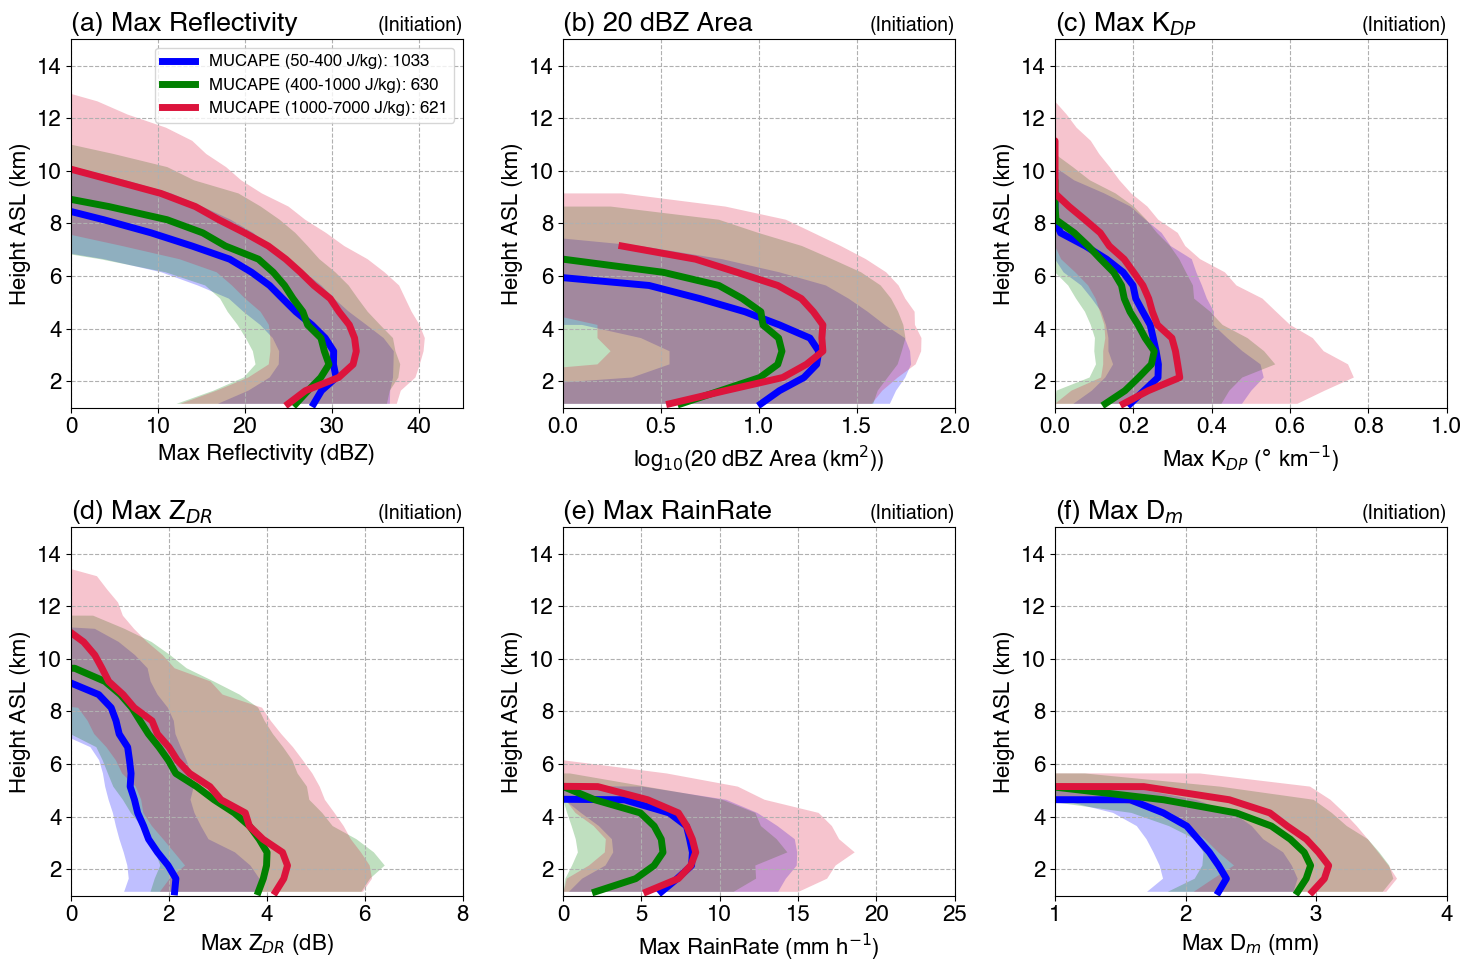

In [48]:
data1_avg = [[max_dbz1_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.5), max_kdp1_prof0_cape_pts.sel(quantile=0.5)],
             [max_zdr1_prof0_cape_pts.sel(quantile=0.5), max_rainrate1_prof0_cape_pts.sel(quantile=0.5), max_Dm1_prof0_cape_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.5), max_kdp2_prof0_cape_pts.sel(quantile=0.5)],
             [max_zdr2_prof0_cape_pts.sel(quantile=0.5), max_rainrate2_prof0_cape_pts.sel(quantile=0.5), max_Dm2_prof0_cape_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.5), max_kdp3_prof0_cape_pts.sel(quantile=0.5)],
             [max_zdr3_prof0_cape_pts.sel(quantile=0.5), max_rainrate3_prof0_cape_pts.sel(quantile=0.5), max_Dm3_prof0_cape_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_prof0_cape_pts.sel(quantile=0.25), max_dbz1_prof0_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.75)), 
              (max_kdp1_prof0_cape_pts.sel(quantile=0.25), max_kdp1_prof0_cape_pts.sel(quantile=0.75))],
             [(max_zdr1_prof0_cape_pts.sel(quantile=0.25), max_zdr1_prof0_cape_pts.sel(quantile=0.75)),
              (max_rainrate1_prof0_cape_pts.sel(quantile=0.25), max_rainrate1_prof0_cape_pts.sel(quantile=0.75)),
              (max_Dm1_prof0_cape_pts.sel(quantile=0.25), max_Dm1_prof0_cape_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_prof0_cape_pts.sel(quantile=0.25), max_dbz2_prof0_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.75)), 
              (max_kdp2_prof0_cape_pts.sel(quantile=0.25), max_kdp2_prof0_cape_pts.sel(quantile=0.75))],
             [(max_zdr2_prof0_cape_pts.sel(quantile=0.25), max_zdr2_prof0_cape_pts.sel(quantile=0.75)),
              (max_rainrate2_prof0_cape_pts.sel(quantile=0.25), max_rainrate2_prof0_cape_pts.sel(quantile=0.75)),
              (max_Dm2_prof0_cape_pts.sel(quantile=0.25), max_Dm2_prof0_cape_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_prof0_cape_pts.sel(quantile=0.25), max_dbz3_prof0_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.75)), 
              (max_kdp3_prof0_cape_pts.sel(quantile=0.25), max_kdp3_prof0_cape_pts.sel(quantile=0.75))],
             [(max_zdr3_prof0_cape_pts.sel(quantile=0.25), max_zdr3_prof0_cape_pts.sel(quantile=0.75)),
              (max_rainrate3_prof0_cape_pts.sel(quantile=0.25), max_rainrate3_prof0_cape_pts.sel(quantile=0.75)),
              (max_Dm3_prof0_cape_pts.sel(quantile=0.25), max_Dm3_prof0_cape_pts.sel(quantile=0.75))]]
xlims = [[(0,45), (0,2.), (0,1.)],
         [(0,8), (0,25), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
figname = f'{figdir}cell_initiation_profile_MUCPAE.png'
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Initiation)'
legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg): {ntracks1_cape}', 
           f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg): {ntracks2_cape}', 
           f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg): {ntracks3_cape}']
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


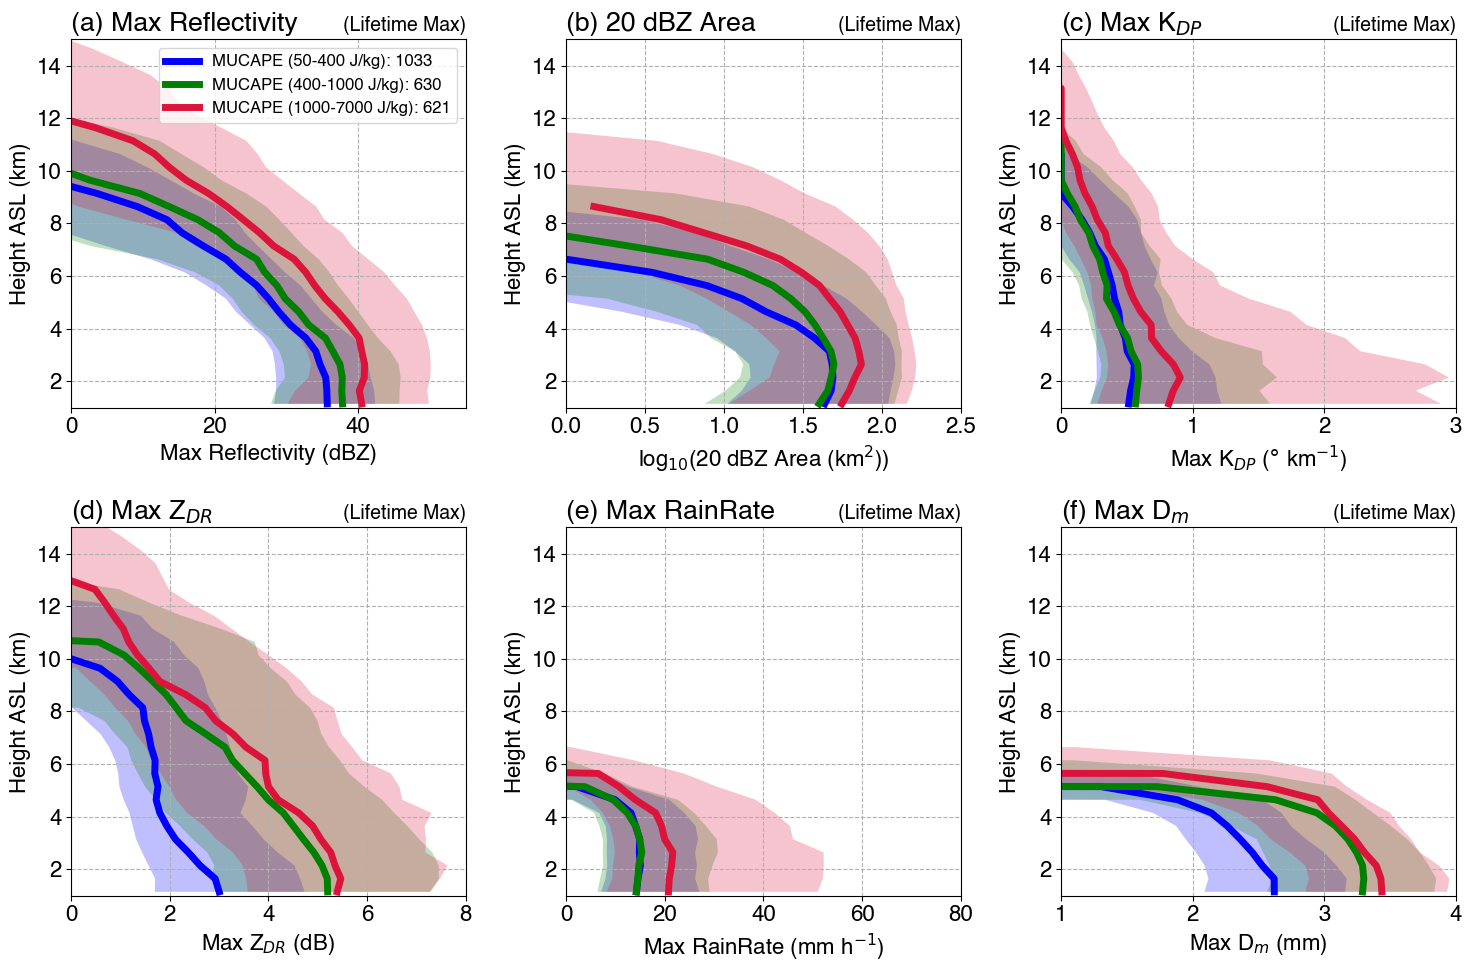

In [49]:
data1_avg = [[max_dbz1_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.5), max_kdp1_maxprof_cape_pts.sel(quantile=0.5)],
             [max_zdr1_maxprof_cape_pts.sel(quantile=0.5), max_rainrate1_maxprof_cape_pts.sel(quantile=0.5), max_Dm1_maxprof_cape_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.5), max_kdp2_maxprof_cape_pts.sel(quantile=0.5)],
             [max_zdr2_maxprof_cape_pts.sel(quantile=0.5), max_rainrate2_maxprof_cape_pts.sel(quantile=0.5), max_Dm2_maxprof_cape_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.5), max_kdp3_maxprof_cape_pts.sel(quantile=0.5)],
             [max_zdr3_maxprof_cape_pts.sel(quantile=0.5), max_rainrate3_maxprof_cape_pts.sel(quantile=0.5), max_Dm3_maxprof_cape_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_maxprof_cape_pts.sel(quantile=0.25), max_dbz1_maxprof_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.75)), 
              (max_kdp1_maxprof_cape_pts.sel(quantile=0.25), max_kdp1_maxprof_cape_pts.sel(quantile=0.75))],
             [(max_zdr1_maxprof_cape_pts.sel(quantile=0.25), max_zdr1_maxprof_cape_pts.sel(quantile=0.75)),
              (max_rainrate1_maxprof_cape_pts.sel(quantile=0.25), max_rainrate1_maxprof_cape_pts.sel(quantile=0.75)),
              (max_Dm1_maxprof_cape_pts.sel(quantile=0.25), max_Dm1_maxprof_cape_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_maxprof_cape_pts.sel(quantile=0.25), max_dbz2_maxprof_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.75)), 
              (max_kdp2_maxprof_cape_pts.sel(quantile=0.25), max_kdp2_maxprof_cape_pts.sel(quantile=0.75))],
             [(max_zdr2_maxprof_cape_pts.sel(quantile=0.25), max_zdr2_maxprof_cape_pts.sel(quantile=0.75)),
              (max_rainrate2_maxprof_cape_pts.sel(quantile=0.25), max_rainrate2_maxprof_cape_pts.sel(quantile=0.75)),
              (max_Dm2_maxprof_cape_pts.sel(quantile=0.25), max_Dm2_maxprof_cape_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_maxprof_cape_pts.sel(quantile=0.25), max_dbz3_maxprof_cape_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.75)), 
              (max_kdp3_maxprof_cape_pts.sel(quantile=0.25), max_kdp3_maxprof_cape_pts.sel(quantile=0.75))],
             [(max_zdr3_maxprof_cape_pts.sel(quantile=0.25), max_zdr3_maxprof_cape_pts.sel(quantile=0.75)),
              (max_rainrate3_maxprof_cape_pts.sel(quantile=0.25), max_rainrate3_maxprof_cape_pts.sel(quantile=0.75)),
              (max_Dm3_maxprof_cape_pts.sel(quantile=0.25), max_Dm3_maxprof_cape_pts.sel(quantile=0.75))]]
xlims = [[(0,55), (0,2.5), (0,3)],
         [(0,8), (0,80), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
figname = f'{figdir}cell_max_profile_MUCPAE.png'
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Lifetime Max)'
legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg): {ntracks1_cape}', 
           f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg): {ntracks2_cape}', 
           f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg): {ntracks3_cape}']
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


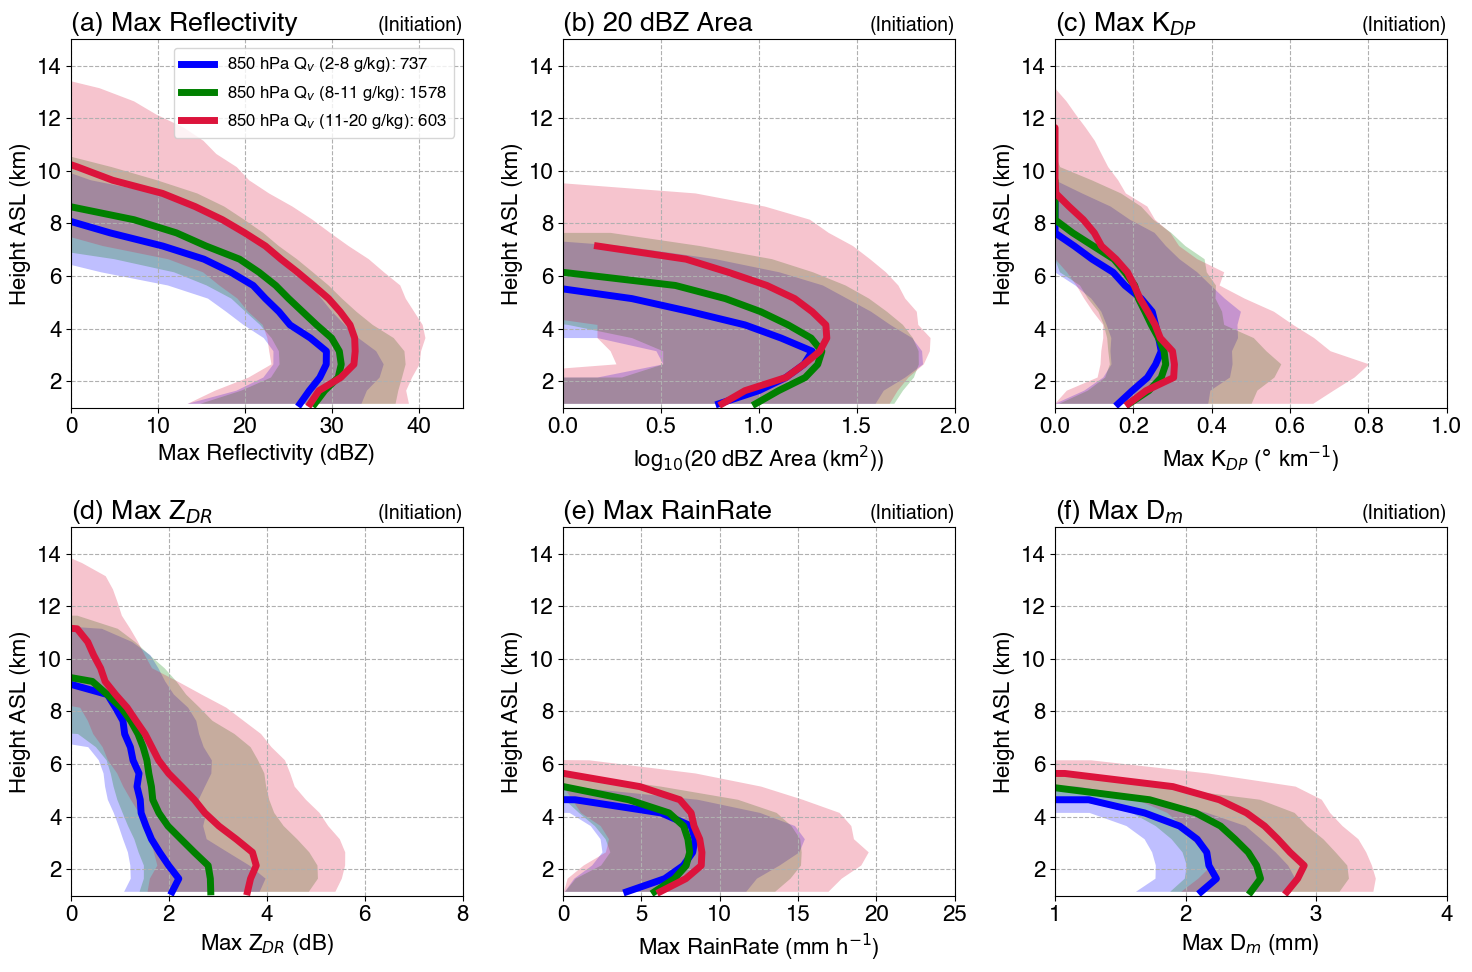

In [50]:
data1_avg = [[max_dbz1_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.5), max_kdp1_prof0_q850p_pts.sel(quantile=0.5)],
             [max_zdr1_prof0_q850p_pts.sel(quantile=0.5), max_rainrate1_prof0_q850p_pts.sel(quantile=0.5), max_Dm1_prof0_q850p_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.5), max_kdp2_prof0_q850p_pts.sel(quantile=0.5)],
             [max_zdr2_prof0_q850p_pts.sel(quantile=0.5), max_rainrate2_prof0_q850p_pts.sel(quantile=0.5), max_Dm2_prof0_q850p_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.5), max_kdp3_prof0_q850p_pts.sel(quantile=0.5)],
             [max_zdr3_prof0_q850p_pts.sel(quantile=0.5), max_rainrate3_prof0_q850p_pts.sel(quantile=0.5), max_Dm3_prof0_q850p_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_prof0_q850p_pts.sel(quantile=0.25), max_dbz1_prof0_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.75)), 
              (max_kdp1_prof0_q850p_pts.sel(quantile=0.25), max_kdp1_prof0_q850p_pts.sel(quantile=0.75))],
             [(max_zdr1_prof0_q850p_pts.sel(quantile=0.25), max_zdr1_prof0_q850p_pts.sel(quantile=0.75)),
              (max_rainrate1_prof0_q850p_pts.sel(quantile=0.25), max_rainrate1_prof0_q850p_pts.sel(quantile=0.75)),
              (max_Dm1_prof0_q850p_pts.sel(quantile=0.25), max_Dm1_prof0_q850p_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_prof0_q850p_pts.sel(quantile=0.25), max_dbz2_prof0_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.75)), 
              (max_kdp2_prof0_q850p_pts.sel(quantile=0.25), max_kdp2_prof0_q850p_pts.sel(quantile=0.75))],
             [(max_zdr2_prof0_q850p_pts.sel(quantile=0.25), max_zdr2_prof0_q850p_pts.sel(quantile=0.75)),
              (max_rainrate2_prof0_q850p_pts.sel(quantile=0.25), max_rainrate2_prof0_q850p_pts.sel(quantile=0.75)),
              (max_Dm2_prof0_q850p_pts.sel(quantile=0.25), max_Dm2_prof0_q850p_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_prof0_q850p_pts.sel(quantile=0.25), max_dbz3_prof0_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.75)), 
              (max_kdp3_prof0_q850p_pts.sel(quantile=0.25), max_kdp3_prof0_q850p_pts.sel(quantile=0.75))],
             [(max_zdr3_prof0_q850p_pts.sel(quantile=0.25), max_zdr3_prof0_q850p_pts.sel(quantile=0.75)),
              (max_rainrate3_prof0_q850p_pts.sel(quantile=0.25), max_rainrate3_prof0_q850p_pts.sel(quantile=0.75)),
              (max_Dm3_prof0_q850p_pts.sel(quantile=0.25), max_Dm3_prof0_q850p_pts.sel(quantile=0.75))]]
xlims = [[(0,45), (0,2.), (0,1.)],
         [(0,8), (0,25), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Initiation)'
legends = [f'850 hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} g/kg): {ntracks1_q850p}', 
           f'850 hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} g/kg): {ntracks2_q850p}', 
           f'850 hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} g/kg): {ntracks3_q850p}']
# figname = f'{figdir}cell_initiation_profile_q850hpa.png'
figname = f'{figdir}cell_initiation_profile_q850hpa.pdf'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


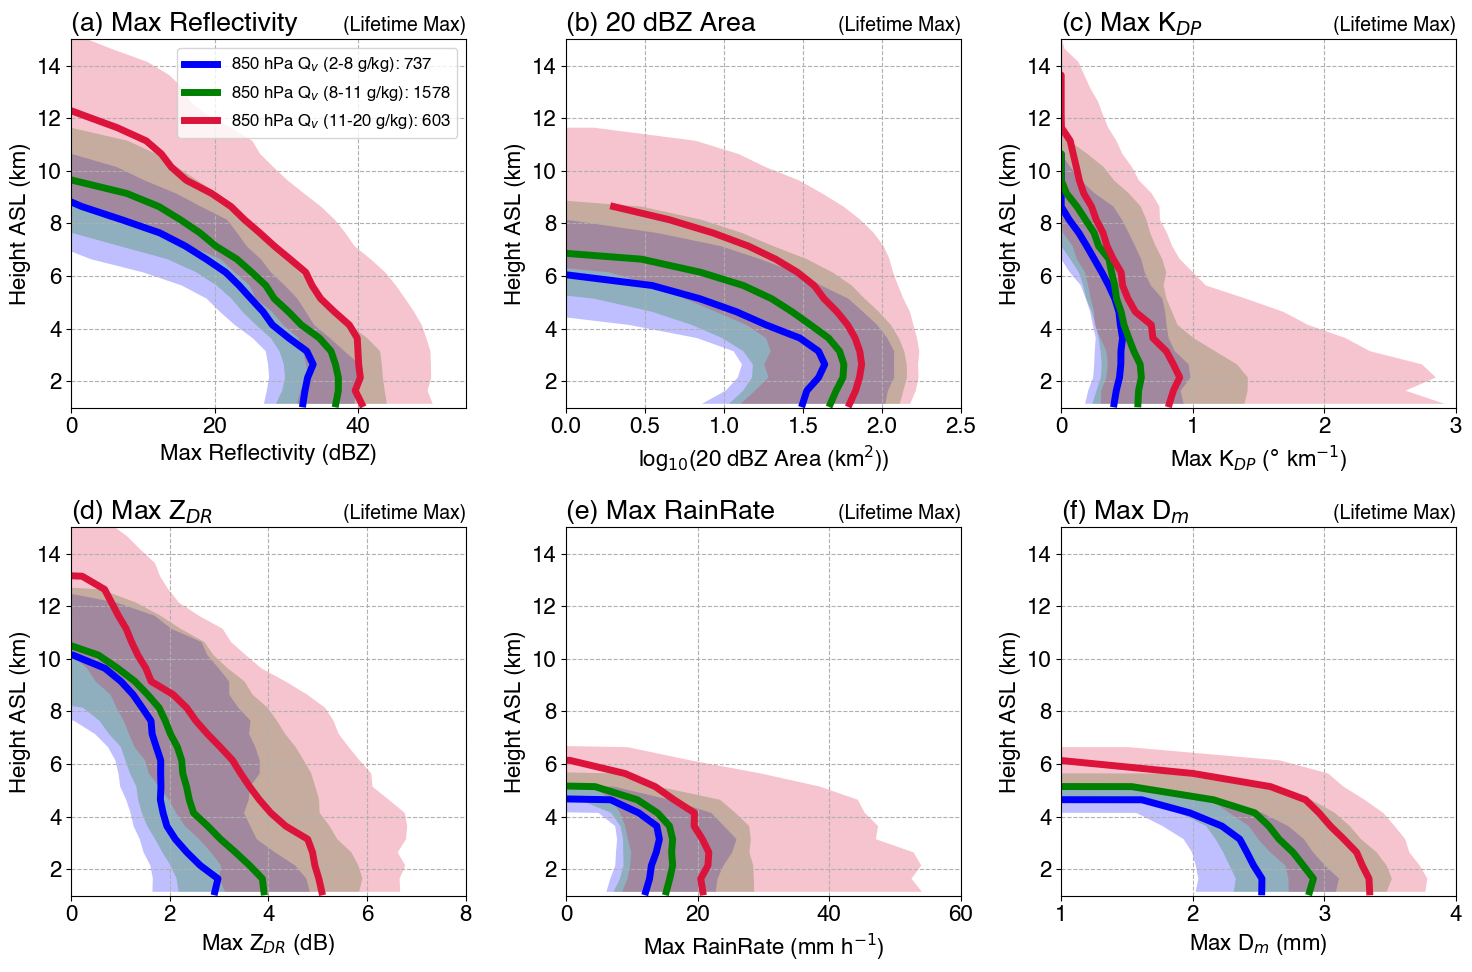

In [51]:
data1_avg = [[max_dbz1_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.5), max_kdp1_maxprof_q850p_pts.sel(quantile=0.5)],
             [max_zdr1_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate1_maxprof_q850p_pts.sel(quantile=0.5), max_Dm1_maxprof_q850p_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.5), max_kdp2_maxprof_q850p_pts.sel(quantile=0.5)],
             [max_zdr2_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate2_maxprof_q850p_pts.sel(quantile=0.5), max_Dm2_maxprof_q850p_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.5), max_kdp3_maxprof_q850p_pts.sel(quantile=0.5)],
             [max_zdr3_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate3_maxprof_q850p_pts.sel(quantile=0.5), max_Dm3_maxprof_q850p_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_maxprof_q850p_pts.sel(quantile=0.25), max_dbz1_maxprof_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.75)), 
              (max_kdp1_maxprof_q850p_pts.sel(quantile=0.25), max_kdp1_maxprof_q850p_pts.sel(quantile=0.75))],
             [(max_zdr1_maxprof_q850p_pts.sel(quantile=0.25), max_zdr1_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_rainrate1_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate1_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_Dm1_maxprof_q850p_pts.sel(quantile=0.25), max_Dm1_maxprof_q850p_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_maxprof_q850p_pts.sel(quantile=0.25), max_dbz2_maxprof_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.75)), 
              (max_kdp2_maxprof_q850p_pts.sel(quantile=0.25), max_kdp2_maxprof_q850p_pts.sel(quantile=0.75))],
             [(max_zdr2_maxprof_q850p_pts.sel(quantile=0.25), max_zdr2_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_rainrate2_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate2_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_Dm2_maxprof_q850p_pts.sel(quantile=0.25), max_Dm2_maxprof_q850p_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_maxprof_q850p_pts.sel(quantile=0.25), max_dbz3_maxprof_q850p_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.75)), 
              (max_kdp3_maxprof_q850p_pts.sel(quantile=0.25), max_kdp3_maxprof_q850p_pts.sel(quantile=0.75))],
             [(max_zdr3_maxprof_q850p_pts.sel(quantile=0.25), max_zdr3_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_rainrate3_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate3_maxprof_q850p_pts.sel(quantile=0.75)),
              (max_Dm3_maxprof_q850p_pts.sel(quantile=0.25), max_Dm3_maxprof_q850p_pts.sel(quantile=0.75))]]
xlims = [[(0,55), (0,2.5), (0,3)],
         [(0,8), (0,60), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Lifetime Max)'
legends = [f'850 hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} g/kg): {ntracks1_q850p}', 
           f'850 hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} g/kg): {ntracks2_q850p}', 
           f'850 hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} g/kg): {ntracks3_q850p}']
figname = f'{figdir}cell_max_profile_q850hpa.png'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


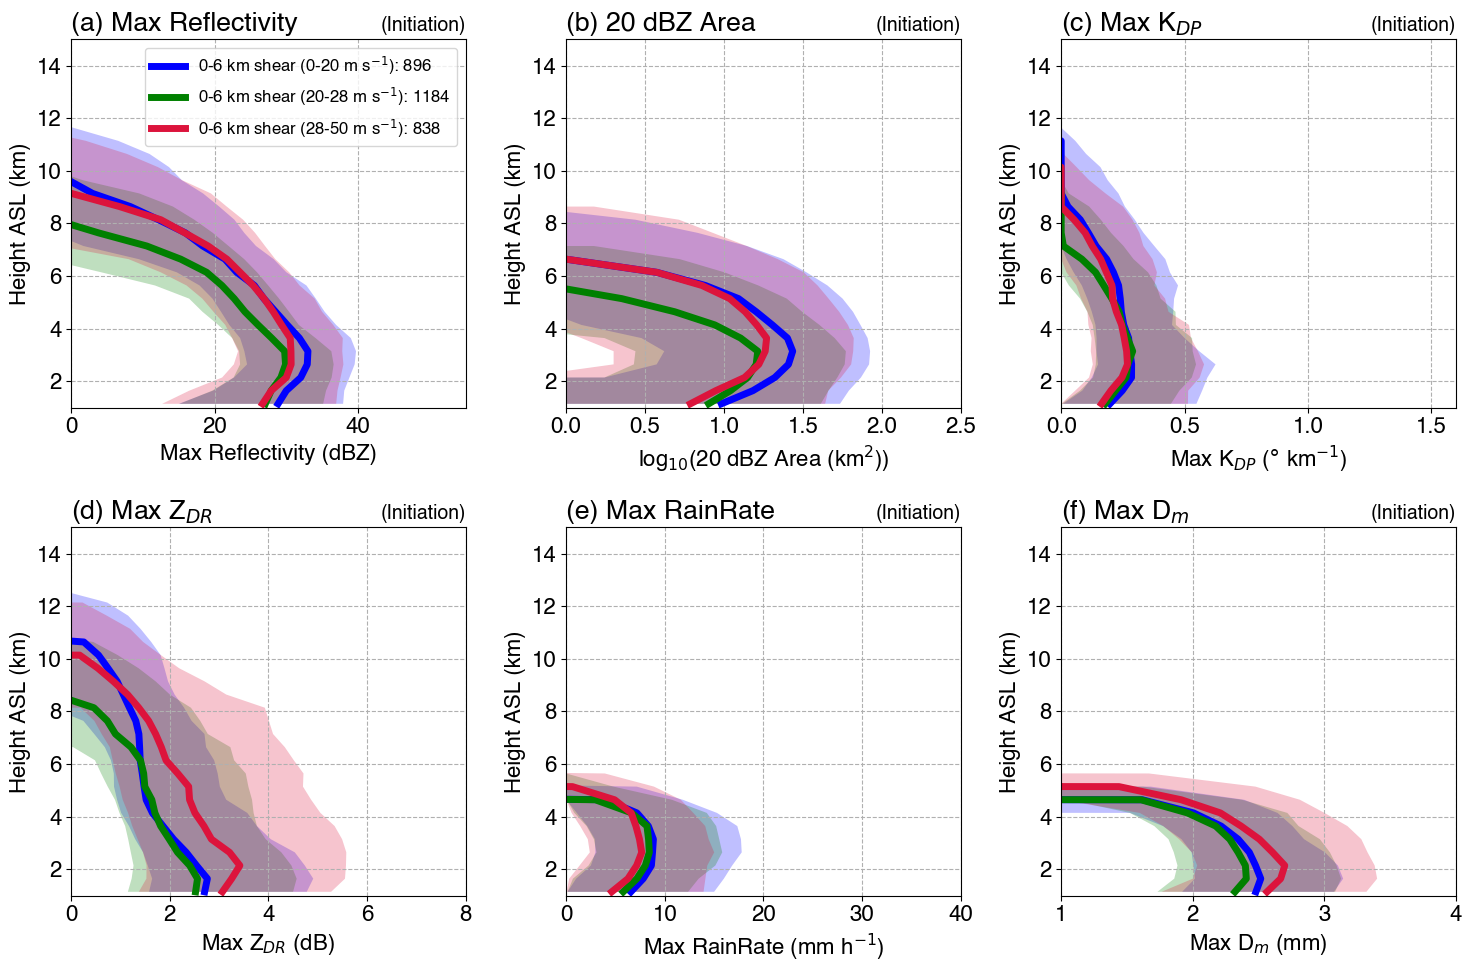

In [52]:
data1_avg = [[max_dbz1_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp1_prof0_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr1_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm1_prof0_shear6mag_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp2_prof0_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr2_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm2_prof0_shear6mag_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp3_prof0_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr3_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm3_prof0_shear6mag_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz1_prof0_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp1_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp1_prof0_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr1_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr1_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm1_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm1_prof0_shear6mag_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz2_prof0_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp2_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp2_prof0_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr2_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr2_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm2_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm2_prof0_shear6mag_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz3_prof0_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp3_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp3_prof0_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr3_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr3_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm3_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm3_prof0_shear6mag_pts.sel(quantile=0.75))]]
xlims = [[(0,55), (0,2.5), (0,1.6)],
         [(0,8), (0,40), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Initiation)'
legends = [f'0-6 km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)'+f': {ntracks1_shear6mag}', 
           f'0-6 km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)'+f': {ntracks2_shear6mag}', 
           f'0-6 km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)'+f': {ntracks3_shear6mag}']
figname = f'{figdir}cell_initiation_profile_shear0-6km.png'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


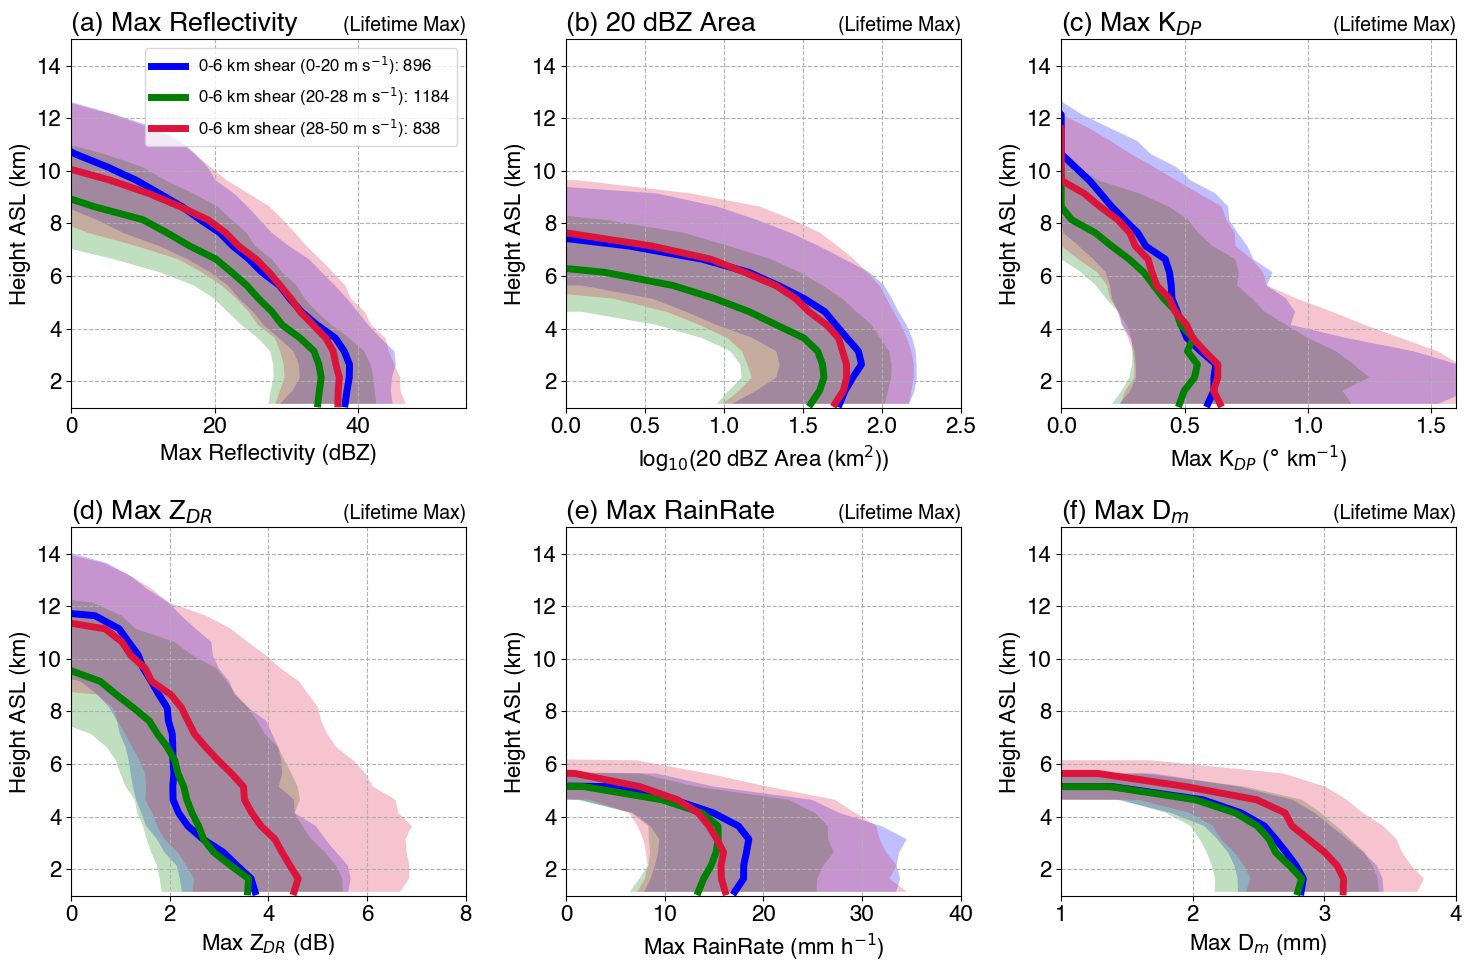

In [53]:
data1_avg = [[max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.5)]]
data2_avg = [[max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.5)]]
data3_avg = [[max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.5)],
             [max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.5)]]
data1_pts = [[(max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.75))]]
data2_pts = [[(max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.75))]]
data3_pts = [[(max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.75)), 
              (np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.75)), 
              (max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.75))],
             [(max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.75)),
              (max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.75))]]
xlims = [[(0,55), (0,2.5), (0,1.6)],
         [(0,8), (0,40), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20 dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
titles1 = [['(a) Max Reflectivity', '(b) 20 dBZ Area', '(c) Max K$_{DP}$',],
           ['(d) Max Z$_{DR}$', '(e) Max RainRate', '(f) Max D$_m$']]
titles2 = '(Lifetime Max)'
legends = [f'0-6 km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)'+f': {ntracks1_shear6mag}', 
           f'0-6 km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)'+f': {ntracks2_shear6mag}', 
           f'0-6 km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)'+f': {ntracks3_shear6mag}']
figname = f'{figdir}cell_max_profile_shear0-6km.png'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height+radar_alt, xlims, xlabels, titles1, titles2, legends, figname)

# Calculates growth rate for long-lived cells

In [54]:
# lifetime_range1 = [1.75,2.0]
lifetime_range1 = [1.75,4.0]
lifetime_ = lifetime.where((start_lon >= lon_eSDC[0]) & (start_lon <= lon_eSDC[1]) &
                    (lifetime >= lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & 
                    (np.isnan(start_split_tracknumber)), drop=True)
# lifetime_ = lifetime.where((start_lon >= lon_eSDC[0]) & (start_lon <= lon_eSDC[1]) &
#                     (lifetime >= lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & 
#                     (np.isnan(end_merge_tracknumber)) & (np.isnan(start_split_tracknumber)), drop=True)
tracknum_long = lifetime_.tracks.values
ntracks_long = len(tracknum_long)
print(f'Number of long-lived tracks: {ntracks_long}')
tracknum_long

Number of long-lived tracks: 252


array([  57,  117,  118,  119,  126,  139,  140,  145,  160,  164,  175,
        195,  203,  314,  318,  330,  385,  444,  518,  562,  564,  569,
        652,  685,  690,  725,  733,  735,  743,  825,  876,  882,  887,
        890,  917,  939,  962, 1009, 1031, 1087, 1128, 1187, 1195, 1202,
       1223, 1225, 1229, 1240, 1275, 1302, 1348, 1446, 1453, 1456, 1457,
       1483, 1485, 1490, 1494, 1507, 1511, 1553, 1558, 1716, 1731, 1742,
       1747, 1756, 1758, 1763, 1788, 1792, 1811, 1819, 1848, 1861, 1866,
       1891, 1911, 1917, 1918, 1932, 1947, 1948, 1953, 1982, 1989, 1992,
       2003, 2004, 2008, 2021, 2038, 2054, 2055, 2071, 2080, 2145, 2152,
       2159, 2397, 2403, 2422, 2477, 2487, 2523, 2563, 2566, 2575, 2618,
       2621, 2645, 2669, 2677, 2678, 2714, 2723, 2731, 2822, 2832, 2871,
       2904, 2947, 2965, 2986, 3038, 3051, 3054, 3063, 3102, 3105, 3117,
       3124, 3128, 3133, 3149, 3152, 3184, 3199, 3230, 3311, 3335, 3339,
       3421, 3433, 3434, 3462, 3475, 3476, 3513, 35

In [55]:
start_lon.shape, lifetime.shape, end_merge_tracknumber.shape, start_split_tracknumber.shape

((6887,), (6887,), (6887,), (6887,))

In [56]:
stats['cell_area'].shape, stats['lifetime'].shape, start_lon.shape,

((6887, 60), (6887,), (6887,))

In [57]:
gap = 1
min_dur = 1
min_rate_percent = 0.1
xtimes = stats.times * time_res

growth_rate_avg1 = np.full(ntracks_long, np.nan, dtype=float)
growth_rate_avg2 = np.full(ntracks_long, np.nan, dtype=float)
growth_rate_avg3 = np.full(ntracks_long, np.nan, dtype=float)

for tn, tracknum in enumerate(tracknum_long):
# for tn, tracknum in enumerate([1456]):
    icell_area = stats['cell_area'].sel(tracks=tracknum)
    iduration = stats['lifetime'].sel(tracks=tracknum).values

    idx = icell_area.values > 0
    x = xtimes.values[idx]
    y = icell_area.values[idx]

    # Fit then then low-pass filter
    Wn1 = 0.2
    X1, Y1, Ys1, dY1 = get_growth_rate1(x, y, iduration, Wn1)
    # Define growth stage
    growth_flag1, dY_thres1 = define_growth_stage(X1, dY1, min_rate_percent, gap, min_dur)
    ns_growth1 = np.count_nonzero(growth_flag1 == 1)
    if (ns_growth1 > 1):
        # dY_hist1, bins = np.histogram(dY1[growth_flag1 == 1])
        growth_rate_avg1[tn] = np.nanmean(dY1[growth_flag1 == 1])
    
    # Low-pass filter then fit
    Wn2 = 0.6
    X2, Ys2, ys2, dY2 = get_growth_rate2(x, y, iduration, Wn2)
    # Define growth stage
    growth_flag2, dY_thres2 = define_growth_stage(X2, dY2, min_rate_percent, gap, min_dur)
    ns_growth2 = np.count_nonzero(growth_flag2 == 1)
    if (ns_growth2 > 1):
        # dY_hist2, bins = np.histogram(dY2[growth_flag2 == 1])
        growth_rate_avg2[tn] = np.nanmean(dY2[growth_flag2 == 1])
        
    # Simple method: (max_area - CI_area) / duration_to_max_area
    ymax_idx = np.argmax(y)
    if (ymax_idx > 0):
        growth_rate_avg3[tn] = (np.nanmax(y) - y[0]) / (x[ymax_idx] - x[0])
        
# Convert to DataArray
growth_rate_avg1 = xr.DataArray(growth_rate_avg1, coords={'tracks':tracknum_long}, dims=['tracks'])
growth_rate_avg2 = xr.DataArray(growth_rate_avg2, coords={'tracks':tracknum_long}, dims=['tracks'])
growth_rate_avg3 = xr.DataArray(growth_rate_avg3, coords={'tracks':tracknum_long}, dims=['tracks'])

In [155]:
# cape_range1, cape_range2, cape_range3
shear6mag_range1, shear6mag_range2, shear6mag_range3

([0, 20], [20, 28], [28, 50])

In [156]:
cape_gr_range1 = [50,400]
cape_gr_range2 = [400,1000]
cape_gr_range3 = [1000,7000]

q850p_gr_range1 = [2,9]
q850p_gr_range2 = [9,12]
q850p_gr_range3 = [12,20]

shear6mag_gr_range1 = [0,20]
shear6mag_gr_range2 = [20,28]
shear6mag_gr_range3 = [28,50]

139.58689381247936 254.21346335676526 338.3386727640872


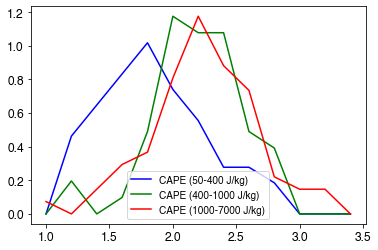

In [157]:
cape_long = cape.sel(tracks=tracknum_long)
q850p_long = q850p.sel(tracks=tracknum_long)
shear6mag_long = shear6mag.sel(tracks=tracknum_long)

gr1_cape1 = growth_rate_avg1.where((cape_long >= cape_gr_range1[0]) & (cape_long < cape_gr_range1[1]), drop=True)
gr1_cape2 = growth_rate_avg1.where((cape_long >= cape_gr_range2[0]) & (cape_long < cape_gr_range2[1]), drop=True)
gr1_cape3 = growth_rate_avg1.where((cape_long >= cape_gr_range3[0]) & (cape_long < cape_gr_range3[1]), drop=True)
print(gr1_cape1.mean().values, gr1_cape2.mean().values, gr1_cape3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr1_cape1, bins = np.histogram(np.log10(gr1_cape1), bins=bins_growthrate, density=True)
pdf_gr1_cape2, bins = np.histogram(np.log10(gr1_cape2), bins=bins_growthrate, density=True)
pdf_gr1_cape3, bins = np.histogram(np.log10(gr1_cape3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr1_cape1, color='b', label=f'CAPE ({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_cape2, color='g', label=f'CAPE ({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_cape3, color='r', label=f'CAPE ({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)')
plt.legend(fontsize=10)

114.8308755894886 199.22797987780132 288.14869705649187


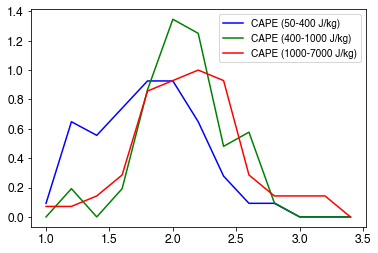

In [158]:
gr2_cape1 = growth_rate_avg2.where((cape_long >= cape_gr_range1[0]) & (cape_long < cape_gr_range1[1]), drop=True)
gr2_cape2 = growth_rate_avg2.where((cape_long >= cape_gr_range2[0]) & (cape_long < cape_gr_range2[1]), drop=True)
gr2_cape3 = growth_rate_avg2.where((cape_long >= cape_gr_range3[0]) & (cape_long < cape_gr_range3[1]), drop=True)
print(gr2_cape1.mean().values, gr2_cape2.mean().values, gr2_cape3.mean().values)
pdf_gr2_cape1, bins = np.histogram(np.log10(gr2_cape1), bins=bins_growthrate, density=True)
pdf_gr2_cape2, bins = np.histogram(np.log10(gr2_cape2), bins=bins_growthrate, density=True)
pdf_gr2_cape3, bins = np.histogram(np.log10(gr2_cape3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr2_cape1, color='b', label=f'CAPE ({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_cape2, color='g', label=f'CAPE ({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_cape3, color='r', label=f'CAPE ({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)')
plt.legend(fontsize=10)

100.92979452054794 193.2554650515177 251.35497967479674


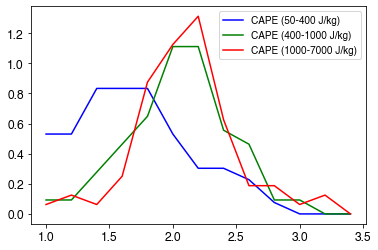

In [159]:
gr3_cape1 = growth_rate_avg3.where((cape_long >= cape_gr_range1[0]) & (cape_long < cape_gr_range1[1]), drop=True)
gr3_cape2 = growth_rate_avg3.where((cape_long >= cape_gr_range2[0]) & (cape_long < cape_gr_range2[1]), drop=True)
gr3_cape3 = growth_rate_avg3.where((cape_long >= cape_gr_range3[0]) & (cape_long < cape_gr_range3[1]), drop=True)
print(gr3_cape1.mean().values, gr3_cape2.mean().values, gr3_cape3.mean().values)
pdf_gr3_cape1, bins = np.histogram(np.log10(gr3_cape1), bins=bins_growthrate, density=True)
pdf_gr3_cape2, bins = np.histogram(np.log10(gr3_cape2), bins=bins_growthrate, density=True)
pdf_gr3_cape3, bins = np.histogram(np.log10(gr3_cape3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr3_cape1, color='b', label=f'CAPE ({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_cape2, color='g', label=f'CAPE ({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_cape3, color='r', label=f'CAPE ({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)')
plt.legend(fontsize=10)

126.84816395657938 224.74569316193126 421.545172948832


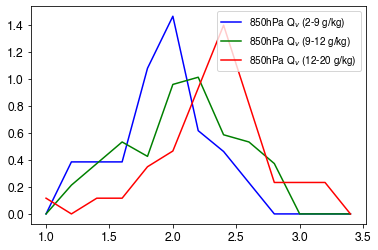

In [160]:
gr1_q850p1 = growth_rate_avg1.where((q850p_long >= q850p_gr_range1[0]) & (q850p_long < q850p_gr_range1[1]), drop=True)
gr1_q850p2 = growth_rate_avg1.where((q850p_long >= q850p_gr_range2[0]) & (q850p_long < q850p_gr_range2[1]), drop=True)
gr1_q850p3 = growth_rate_avg1.where((q850p_long >= q850p_gr_range3[0]) & (q850p_long < q850p_gr_range3[1]), drop=True)
print(gr1_q850p1.mean().values, gr1_q850p2.mean().values, gr1_q850p3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr1_q850p1, bins = np.histogram(np.log10(gr1_q850p1), bins=bins_growthrate, density=True)
pdf_gr1_q850p2, bins = np.histogram(np.log10(gr1_q850p2), bins=bins_growthrate, density=True)
pdf_gr1_q850p3, bins = np.histogram(np.log10(gr1_q850p3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr1_q850p1, color='b', label=f'850hPa Q$_v$ ({q850p_gr_range1[0]}-{q850p_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_q850p2, color='g', label=f'850hPa Q$_v$ ({q850p_gr_range2[0]}-{q850p_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_q850p3, color='r', label=f'850hPa Q$_v$ ({q850p_gr_range3[0]}-{q850p_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

109.83957418901538 178.5053335049889 356.8491464917782


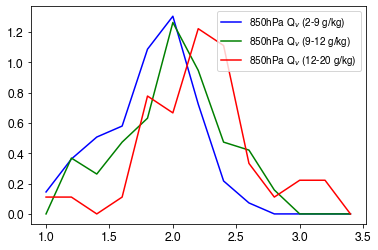

In [161]:
gr2_q850p1 = growth_rate_avg2.where((q850p_long >= q850p_gr_range1[0]) & (q850p_long < q850p_gr_range1[1]), drop=True)
gr2_q850p2 = growth_rate_avg2.where((q850p_long >= q850p_gr_range2[0]) & (q850p_long < q850p_gr_range2[1]), drop=True)
gr2_q850p3 = growth_rate_avg2.where((q850p_long >= q850p_gr_range3[0]) & (q850p_long < q850p_gr_range3[1]), drop=True)
print(gr2_q850p1.mean().values, gr2_q850p2.mean().values, gr2_q850p3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr2_q850p1, bins = np.histogram(np.log10(gr2_q850p1), bins=bins_growthrate, density=True)
pdf_gr2_q850p2, bins = np.histogram(np.log10(gr2_q850p2), bins=bins_growthrate, density=True)
pdf_gr2_q850p3, bins = np.histogram(np.log10(gr2_q850p3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr2_q850p1, color='b', label=f'850hPa Q$_v$ ({q850p_gr_range1[0]}-{q850p_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_q850p2, color='g', label=f'850hPa Q$_v$ ({q850p_gr_range2[0]}-{q850p_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_q850p3, color='r', label=f'850hPa Q$_v$ ({q850p_gr_range3[0]}-{q850p_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

91.70458978772231 166.33834105913752 302.4736373165618


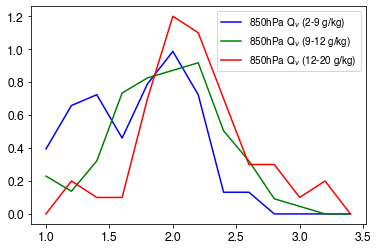

In [162]:
gr3_q850p1 = growth_rate_avg3.where((q850p_long >= q850p_gr_range1[0]) & (q850p_long < q850p_gr_range1[1]), drop=True)
gr3_q850p2 = growth_rate_avg3.where((q850p_long >= q850p_gr_range2[0]) & (q850p_long < q850p_gr_range2[1]), drop=True)
gr3_q850p3 = growth_rate_avg3.where((q850p_long >= q850p_gr_range3[0]) & (q850p_long < q850p_gr_range3[1]), drop=True)
print(gr3_q850p1.mean().values, gr3_q850p2.mean().values, gr3_q850p3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr3_q850p1, bins = np.histogram(np.log10(gr3_q850p1), bins=bins_growthrate, density=True)
pdf_gr3_q850p2, bins = np.histogram(np.log10(gr3_q850p2), bins=bins_growthrate, density=True)
pdf_gr3_q850p3, bins = np.histogram(np.log10(gr3_q850p3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr3_q850p1, color='b', label=f'850hPa Q$_v$ ({q850p_gr_range1[0]}-{q850p_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_q850p2, color='g', label=f'850hPa Q$_v$ ({q850p_gr_range2[0]}-{q850p_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_q850p3, color='r', label=f'850hPa Q$_v$ ({q850p_gr_range3[0]}-{q850p_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

160.65337370829045 167.91055145340292 373.1469143840132


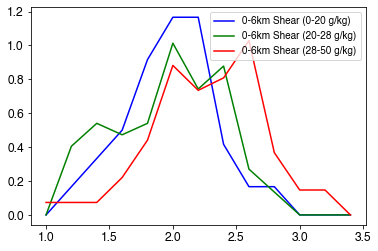

In [163]:
gr1_shear6mag1 = growth_rate_avg1.where((shear6mag_long >= shear6mag_gr_range1[0]) & (shear6mag_long < shear6mag_gr_range1[1]), drop=True)
gr1_shear6mag2 = growth_rate_avg1.where((shear6mag_long >= shear6mag_gr_range2[0]) & (shear6mag_long < shear6mag_gr_range2[1]), drop=True)
gr1_shear6mag3 = growth_rate_avg1.where((shear6mag_long >= shear6mag_gr_range3[0]) & (shear6mag_long < shear6mag_gr_range3[1]), drop=True)
print(gr1_shear6mag1.mean().values, gr1_shear6mag2.mean().values, gr1_shear6mag3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr1_shear6mag1, bins = np.histogram(np.log10(gr1_shear6mag1), bins=bins_growthrate, density=True)
pdf_gr1_shear6mag2, bins = np.histogram(np.log10(gr1_shear6mag2), bins=bins_growthrate, density=True)
pdf_gr1_shear6mag3, bins = np.histogram(np.log10(gr1_shear6mag3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr1_shear6mag1, color='b', label=f'0-6km Shear ({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_shear6mag2, color='g', label=f'0-6km Shear ({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr1_shear6mag3, color='r', label=f'0-6km Shear ({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

132.30335687221782 139.78841922321047 306.8444654309816


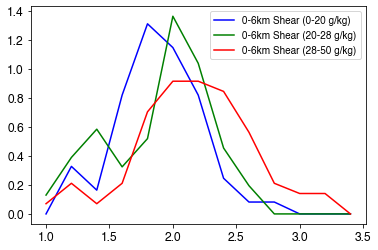

In [164]:
gr2_shear6mag1 = growth_rate_avg2.where((shear6mag_long >= shear6mag_gr_range1[0]) & (shear6mag_long < shear6mag_gr_range1[1]), drop=True)
gr2_shear6mag2 = growth_rate_avg2.where((shear6mag_long >= shear6mag_gr_range2[0]) & (shear6mag_long < shear6mag_gr_range2[1]), drop=True)
gr2_shear6mag3 = growth_rate_avg2.where((shear6mag_long >= shear6mag_gr_range3[0]) & (shear6mag_long < shear6mag_gr_range3[1]), drop=True)
print(gr2_shear6mag1.mean().values, gr2_shear6mag2.mean().values, gr2_shear6mag3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr2_shear6mag1, bins = np.histogram(np.log10(gr2_shear6mag1), bins=bins_growthrate, density=True)
pdf_gr2_shear6mag2, bins = np.histogram(np.log10(gr2_shear6mag2), bins=bins_growthrate, density=True)
pdf_gr2_shear6mag3, bins = np.histogram(np.log10(gr2_shear6mag3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr2_shear6mag1, color='b', label=f'0-6km Shear ({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_shear6mag2, color='g', label=f'0-6km Shear ({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr2_shear6mag3, color='r', label=f'0-6km Shear ({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

120.8400740740741 118.72003546099293 277.70159226190475


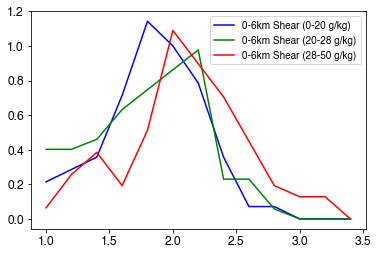

In [165]:
gr3_shear6mag1 = growth_rate_avg3.where((shear6mag_long >= shear6mag_gr_range1[0]) & (shear6mag_long < shear6mag_gr_range1[1]), drop=True)
gr3_shear6mag2 = growth_rate_avg3.where((shear6mag_long >= shear6mag_gr_range2[0]) & (shear6mag_long < shear6mag_gr_range2[1]), drop=True)
gr3_shear6mag3 = growth_rate_avg3.where((shear6mag_long >= shear6mag_gr_range3[0]) & (shear6mag_long < shear6mag_gr_range3[1]), drop=True)
print(gr3_shear6mag1.mean().values, gr3_shear6mag2.mean().values, gr3_shear6mag3.mean().values)
bins_growthrate = np.arange(1, 3.61, 0.2)
pdf_gr3_shear6mag1, bins = np.histogram(np.log10(gr3_shear6mag1), bins=bins_growthrate, density=True)
pdf_gr3_shear6mag2, bins = np.histogram(np.log10(gr3_shear6mag2), bins=bins_growthrate, density=True)
pdf_gr3_shear6mag3, bins = np.histogram(np.log10(gr3_shear6mag3), bins=bins_growthrate, density=True)
plt.plot(bins_growthrate[:-1], pdf_gr3_shear6mag1, color='b', label=f'0-6km Shear ({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_shear6mag2, color='g', label=f'0-6km Shear ({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]}'+' g/kg)')
plt.plot(bins_growthrate[:-1], pdf_gr3_shear6mag3, color='r', label=f'0-6km Shear ({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]}'+' g/kg)')
plt.legend(fontsize=10)

In [166]:
ns_gr1_cape1 = np.count_nonzero(~np.isnan(gr1_cape1))
ns_gr1_cape2 = np.count_nonzero(~np.isnan(gr1_cape3))
ns_gr1_cape3 = np.count_nonzero(~np.isnan(gr1_cape2))
print(f'Sample CAPE method1: {ns_gr1_cape1}, {ns_gr1_cape2}, {ns_gr1_cape3}')
ns_gr2_cape1 = np.count_nonzero(~np.isnan(gr2_cape1))
ns_gr2_cape2 = np.count_nonzero(~np.isnan(gr2_cape3))
ns_gr2_cape3 = np.count_nonzero(~np.isnan(gr2_cape2))
print(f'Sample CAPE method2: {ns_gr2_cape1}, {ns_gr2_cape2}, {ns_gr2_cape3}')
ns_gr3_cape1 = np.count_nonzero(~np.isnan(gr3_cape1))
ns_gr3_cape2 = np.count_nonzero(~np.isnan(gr3_cape3))
ns_gr3_cape3 = np.count_nonzero(~np.isnan(gr3_cape2))
print(f'Sample CAPE method3: {ns_gr3_cape1}, {ns_gr3_cape2}, {ns_gr3_cape3}')

ns_gr1_q850p1 = np.count_nonzero(~np.isnan(gr1_q850p1))
ns_gr1_q850p2 = np.count_nonzero(~np.isnan(gr1_q850p3))
ns_gr1_q850p3 = np.count_nonzero(~np.isnan(gr1_q850p2))
print(f'Sample q850p method1: {ns_gr1_q850p1}, {ns_gr1_q850p2}, {ns_gr1_q850p3}')
ns_gr2_q850p1 = np.count_nonzero(~np.isnan(gr2_q850p1))
ns_gr2_q850p2 = np.count_nonzero(~np.isnan(gr2_q850p3))
ns_gr2_q850p3 = np.count_nonzero(~np.isnan(gr2_q850p2))
print(f'Sample q850p method2: {ns_gr2_q850p1}, {ns_gr2_q850p2}, {ns_gr2_q850p3}')
ns_gr3_q850p1 = np.count_nonzero(~np.isnan(gr3_q850p1))
ns_gr3_q850p2 = np.count_nonzero(~np.isnan(gr3_q850p3))
ns_gr3_q850p3 = np.count_nonzero(~np.isnan(gr3_q850p2))
print(f'Sample q850p method3: {ns_gr3_q850p1}, {ns_gr3_q850p2}, {ns_gr3_q850p3}')

ns_gr1_shear6mag1 = np.count_nonzero(~np.isnan(gr1_shear6mag1))
ns_gr1_shear6mag2 = np.count_nonzero(~np.isnan(gr1_shear6mag3))
ns_gr1_shear6mag3 = np.count_nonzero(~np.isnan(gr1_shear6mag2))
print(f'Sample shear6mag method1: {ns_gr1_shear6mag1}, {ns_gr1_shear6mag2}, {ns_gr1_shear6mag3}')
ns_gr2_shear6mag1 = np.count_nonzero(~np.isnan(gr2_shear6mag1))
ns_gr2_shear6mag2 = np.count_nonzero(~np.isnan(gr2_shear6mag3))
ns_gr2_shear6mag3 = np.count_nonzero(~np.isnan(gr2_shear6mag2))
print(f'Sample shear6mag method2: {ns_gr2_shear6mag1}, {ns_gr2_shear6mag2}, {ns_gr2_shear6mag3}')
ns_gr3_shear6mag1 = np.count_nonzero(~np.isnan(gr3_shear6mag1))
ns_gr3_shear6mag2 = np.count_nonzero(~np.isnan(gr3_shear6mag3))
ns_gr3_shear6mag3 = np.count_nonzero(~np.isnan(gr3_shear6mag2))
print(f'Sample shear6mag method3: {ns_gr3_shear6mag1}, {ns_gr3_shear6mag2}, {ns_gr3_shear6mag3}')

Sample CAPE method1: 56, 68, 52
Sample CAPE method2: 57, 70, 53
Sample CAPE method3: 73, 82, 57
Sample q850p method1: 68, 43, 95
Sample q850p method2: 71, 45, 97
Sample q850p method3: 83, 53, 113
Sample shear6mag method1: 61, 68, 77
Sample shear6mag method2: 62, 71, 80
Sample shear6mag method3: 75, 80, 94


In [167]:
def plot_2kde(data1, data2, labels1, labels2, titles, xlabel, figname):

    mpl.rcParams['font.size'] = 16
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), dpi=100)

    lw_kde = 4
    colors = {'low':'blue', 'medium':'green', 'high':'crimson'}

    ax = axes[0]
    kde1 = sns.kdeplot(np.log10(data1[0]), color=colors['low'], lw=lw_kde, label=labels1[0], ax=ax)
    kde2 = sns.kdeplot(np.log10(data1[1]), color=colors['medium'], lw=lw_kde, label=labels1[1], ax=ax)
    kde3 = sns.kdeplot(np.log10(data1[2]), color=colors['high'], lw=lw_kde, label=labels1[2], ax=ax)
    avg1 = data1[0].mean().values
    avg2 = data1[1].mean().values
    avg3 = data1[2].mean().values
    ax.axvline(np.log10(avg1), color=colors['low'], ls='--')
    ax.axvline(np.log10(avg2), color=colors['medium'], ls='--')
    ax.axvline(np.log10(avg3), color=colors['high'], ls='--')
    ax.grid(ls='--')
    ax.set_xlabel(xlabel)
    ax.set_title(titles[0], loc='left')
    legend1 = ax.legend(fontsize=13)
    legend_avg = [mpl.lines.Line2D([0], [0], color=colors['low'], ls='none', label=f'{avg1:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['medium'], ls='none', label=f'{avg2:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['high'], ls='none', label=f'{avg3:.0f}'+' (km$^2$ h$^{-1}$)'),]
    legend2 = ax.legend(handles=legend_avg, handlelength=0, handletextpad=0, loc='upper right', fontsize=13, labelcolor='linecolor')
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax = axes[1]
    kde1 = sns.kdeplot(np.log10(data1[0]), color=colors['low'], lw=lw_kde, label=labels2[0], ax=ax)
    kde2 = sns.kdeplot(np.log10(data1[1]), color=colors['medium'], lw=lw_kde, label=labels2[1], ax=ax)
    kde3 = sns.kdeplot(np.log10(data1[2]), color=colors['high'], lw=lw_kde, label=labels2[2], ax=ax)
    avg1 = data1[0].mean().values
    avg2 = data1[1].mean().values
    avg3 = data1[2].mean().values
    ax.axvline(np.log10(avg1), color=colors['low'], ls='--')
    ax.axvline(np.log10(avg2), color=colors['medium'], ls='--')
    ax.axvline(np.log10(avg3), color=colors['high'], ls='--')
    ax.grid(ls='--')
    ax.set_xlabel(xlabel)
    ax.set_title(titles[1], loc='left')
    legend1 = ax.legend(fontsize=13)
    legend_avg = [mpl.lines.Line2D([0], [0], color=colors['low'], ls='none', label=f'{avg1:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['medium'], ls='none', label=f'{avg2:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['high'], ls='none', label=f'{avg3:.0f}'+' (km$^2$ h$^{-1}$)'),]
    legend2 = ax.legend(handles=legend_avg, handlelength=0, handletextpad=0, loc='upper right', fontsize=13, labelcolor='linecolor')
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')
    return fig

In [168]:
# data1 = [gr1_cape1, gr1_cape2, gr1_cape3]
# data2 = [gr1_q850p1, gr1_q850p2, gr1_q850p3]
# labels1 = [f'{cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg ({ns_gr1_cape1})',
#            f'{cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg ({ns_gr1_cape2})',
#            f'{cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg ({ns_gr1_cape3})']
# labels2 = [f'{q850p_gr_range1[0]}-{q850p_gr_range1[1]} g/kg ({ns_gr1_q850p1})',
#            f'{q850p_gr_range2[0]}-{q850p_gr_range2[1]} g/kg ({ns_gr1_q850p2})',
#            f'{q850p_gr_range3[0]}-{q850p_gr_range3[1]} g/kg ({ns_gr1_q850p3})']
# titles = ['(a) Cell Area Growth Rate by MUCAPE',
#           '(b) Cell Area Growth Rate by 850 hPa Q$_v$']
# xlabel = 'Log$_{10}$(Area Growth Rate (km$^2$ h$^{-1}$))'
# figname = f'{figdir}cellarea_growthrate_pdf_MUCAPE_qv850mb_method1.png'
# fig = plot_2kde(data1, data2, labels1, labels2, titles, xlabel, figname)

In [169]:
# data1 = [gr2_cape1, gr2_cape2, gr2_cape3]
# data2 = [gr2_q850p1, gr2_q850p2, gr2_q850p3]
# labels1 = [f'{cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg ({ns_gr2_cape1})',
#            f'{cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg ({ns_gr2_cape2})',
#            f'{cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg ({ns_gr2_cape3})']
# labels2 = [f'{q850p_gr_range1[0]}-{q850p_gr_range1[1]} g/kg ({ns_gr2_q850p1})',
#            f'{q850p_gr_range2[0]}-{q850p_gr_range2[1]} g/kg ({ns_gr2_q850p2})',
#            f'{q850p_gr_range3[0]}-{q850p_gr_range3[1]} g/kg ({ns_gr2_q850p3})']
# titles = ['(a) Cell Area Growth Rate by MUCAPE',
#           '(b) Cell Area Growth Rate by 850 hPa Q$_v$']
# xlabel = 'Log$_{10}$(Area Growth Rate (km$^2$ h$^{-1}$))'
# figname = f'{figdir}cellarea_growthrate_pdf_MUCAPE_qv850mb_method2.png'
# fig = plot_2kde(data1, data2, labels1, labels2, titles, xlabel, figname)

In [170]:
def ttest_data(data1, data2, name):
    # compare samples
    stat, p = ttest_ind(data1, data2)
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{name}: Same distributions')
        sig = '$\\times$'
    else:
        print(f'{name}: Different distributions')
        sig = '$\checkmark$'
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    return sig

In [185]:
def kstest_data(data1, data2, name):
    # compare samples
    stat, p = ks_2samp(data1, data2)
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{name}: Same distributions')
        sig = '$\\times$'
    else:
        print(f'{name}: Different distributions')
        sig = '$\checkmark$'
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    return sig

In [187]:
sig1_cape12 = ttest_data(gr1_cape1[~np.isnan(gr1_cape1)], gr1_cape2[~np.isnan(gr1_cape2)], 'GR1-MUCAPE Low vs. Medium')
sig1_cape23 = ttest_data(gr1_cape2[~np.isnan(gr1_cape2)], gr1_cape3[~np.isnan(gr1_cape3)], 'GR1-MUCAPE Medium vs. High')
sig1_cape13 = ttest_data(gr1_cape1[~np.isnan(gr1_cape1)], gr1_cape3[~np.isnan(gr1_cape3)], 'GR1-MUCAPE Low vs. High')
sig1_q850p12 = ttest_data(gr1_q850p1[~np.isnan(gr1_q850p1)], gr1_q850p2[~np.isnan(gr1_q850p2)], 'GR1-Qv850 Low vs. Medium')
sig1_q850p23 = ttest_data(gr1_q850p2[~np.isnan(gr1_q850p2)], gr1_q850p3[~np.isnan(gr1_q850p3)], 'GR1-Qv850 Medium vs. High')
sig1_q850p13 = ttest_data(gr1_q850p1[~np.isnan(gr1_q850p1)], gr1_q850p3[~np.isnan(gr1_q850p3)], 'GR1-Qv850 Low vs. High')
sig1_shear6mag12 = ttest_data(gr1_shear6mag1[~np.isnan(gr1_shear6mag1)], gr1_shear6mag2[~np.isnan(gr1_shear6mag2)], 'GR1-Shear6km Low vs. Medium')
sig1_shear6mag23 = ttest_data(gr1_shear6mag2[~np.isnan(gr1_shear6mag2)], gr1_shear6mag3[~np.isnan(gr1_shear6mag3)], 'GR1-Shear6km Medium vs. High')
sig1_shear6mag13 = ttest_data(gr1_shear6mag1[~np.isnan(gr1_shear6mag1)], gr1_shear6mag3[~np.isnan(gr1_shear6mag3)], 'GR1-Shear6km Low vs. High')

GR1-MUCAPE Low vs. Medium: Different distributions
Statistics=-3.116, p=0.002
GR1-MUCAPE Medium vs. High: Same distributions
Statistics=-1.363, p=0.176
GR1-MUCAPE Low vs. High: Different distributions
Statistics=-3.430, p=0.001
GR1-Qv850 Low vs. Medium: Different distributions
Statistics=-3.465, p=0.001
GR1-Qv850 Medium vs. High: Different distributions
Statistics=-3.364, p=0.001
GR1-Qv850 Low vs. High: Different distributions
Statistics=-4.935, p=0.000
GR1-Shear6km Low vs. Medium: Same distributions
Statistics=-0.270, p=0.787
GR1-Shear6km Medium vs. High: Different distributions
Statistics=-4.007, p=0.000
GR1-Shear6km Low vs. High: Different distributions
Statistics=-3.785, p=0.000


In [172]:
sig2_cape12 = ttest_data(gr2_cape1[~np.isnan(gr2_cape1)], gr2_cape2[~np.isnan(gr2_cape2)], 'GR2-MUCAPE Low vs. Medium')
sig2_cape23 = ttest_data(gr2_cape2[~np.isnan(gr2_cape2)], gr2_cape3[~np.isnan(gr2_cape3)], 'GR2-MUCAPE Medium vs. High')
sig2_cape13 = ttest_data(gr2_cape1[~np.isnan(gr2_cape1)], gr2_cape3[~np.isnan(gr2_cape3)], 'GR2-MUCAPE Low vs. High')
sig2_q850p12 = ttest_data(gr2_q850p1[~np.isnan(gr2_q850p1)], gr2_q850p2[~np.isnan(gr2_q850p2)], 'GR2-Qv850 Low vs. Medium')
sig2_q850p23 = ttest_data(gr2_q850p2[~np.isnan(gr2_q850p2)], gr2_q850p3[~np.isnan(gr2_q850p3)], 'GR2-Qv850 Medium vs. High')
sig2_q850p13 = ttest_data(gr2_q850p1[~np.isnan(gr2_q850p1)], gr2_q850p3[~np.isnan(gr2_q850p3)], 'GR2-Qv850 Low vs. High')
sig2_shear6mag12 = ttest_data(gr2_shear6mag1[~np.isnan(gr2_shear6mag1)], gr2_shear6mag2[~np.isnan(gr2_shear6mag2)], 'GR2-Shear6km Low vs. Medium')
sig2_shear6mag23 = ttest_data(gr2_shear6mag2[~np.isnan(gr2_shear6mag2)], gr2_shear6mag3[~np.isnan(gr2_shear6mag3)], 'GR2-Shear6km Medium vs. High')
sig2_shear6mag13 = ttest_data(gr2_shear6mag1[~np.isnan(gr2_shear6mag1)], gr2_shear6mag3[~np.isnan(gr2_shear6mag3)], 'GR2-Shear6km Low vs. High')

GR2-MUCAPE Low vs. Medium: Different distributions
Statistics=-3.050, p=0.003
GR2-MUCAPE Medium vs. High: Same distributions
Statistics=-1.603, p=0.112
GR2-MUCAPE Low vs. High: Different distributions
Statistics=-3.277, p=0.001
GR2-Qv850 Low vs. Medium: Different distributions
Statistics=-3.154, p=0.002
GR2-Qv850 Medium vs. High: Different distributions
Statistics=-3.452, p=0.001
GR2-Qv850 Low vs. High: Different distributions
Statistics=-4.498, p=0.000
GR2-Shear6km Low vs. Medium: Same distributions
Statistics=-0.346, p=0.730
GR2-Shear6km Medium vs. High: Different distributions
Statistics=-3.695, p=0.000
GR2-Shear6km Low vs. High: Different distributions
Statistics=-3.444, p=0.001


In [173]:
sig3_cape12 = ttest_data(gr3_cape1[~np.isnan(gr3_cape1)], gr3_cape2[~np.isnan(gr3_cape2)], 'GR3-MUCAPE Low vs. Medium')
sig3_cape23 = ttest_data(gr3_cape2[~np.isnan(gr3_cape2)], gr3_cape3[~np.isnan(gr3_cape3)], 'GR3-MUCAPE Medium vs. High')
sig3_cape13 = ttest_data(gr3_cape1[~np.isnan(gr3_cape1)], gr3_cape3[~np.isnan(gr3_cape3)], 'GR3-MUCAPE Low vs. High')
sig3_q850p12 = ttest_data(gr3_q850p1[~np.isnan(gr3_q850p1)], gr3_q850p2[~np.isnan(gr3_q850p2)], 'GR3-Qv850 Low vs. Medium')
sig3_q850p23 = ttest_data(gr3_q850p2[~np.isnan(gr3_q850p2)], gr3_q850p3[~np.isnan(gr3_q850p3)], 'GR3-Qv850 Medium vs. High')
sig3_q850p13 = ttest_data(gr3_q850p1[~np.isnan(gr3_q850p1)], gr3_q850p3[~np.isnan(gr3_q850p3)], 'GR3-Qv850 Low vs. High')
sig3_shear6mag12 = ttest_data(gr3_shear6mag1[~np.isnan(gr3_shear6mag1)], gr3_shear6mag2[~np.isnan(gr3_shear6mag2)], 'GR3-Shear6km Low vs. Medium')
sig3_shear6mag23 = ttest_data(gr3_shear6mag2[~np.isnan(gr3_shear6mag2)], gr3_shear6mag3[~np.isnan(gr3_shear6mag3)], 'GR3-Shear6km Medium vs. High')
sig3_shear6mag13 = ttest_data(gr3_shear6mag1[~np.isnan(gr3_shear6mag1)], gr3_shear6mag3[~np.isnan(gr3_shear6mag3)], 'GR3-Shear6km Low vs. High')

GR3-MUCAPE Low vs. Medium: Different distributions
Statistics=-3.061, p=0.003
GR3-MUCAPE Medium vs. High: Same distributions
Statistics=-1.138, p=0.257
GR3-MUCAPE Low vs. High: Different distributions
Statistics=-3.429, p=0.001
GR3-Qv850 Low vs. Medium: Different distributions
Statistics=-3.449, p=0.001
GR3-Qv850 Medium vs. High: Different distributions
Statistics=-2.933, p=0.004
GR3-Qv850 Low vs. High: Different distributions
Statistics=-4.414, p=0.000
GR3-Shear6km Low vs. Medium: Same distributions
Statistics=0.106, p=0.916
GR3-Shear6km Medium vs. High: Different distributions
Statistics=-3.892, p=0.000
GR3-Shear6km Low vs. High: Different distributions
Statistics=-3.494, p=0.001


In [189]:
KSsig1_cape12 = kstest_data(gr1_cape1[~np.isnan(gr1_cape1)], gr1_cape2[~np.isnan(gr1_cape2)], 'GR1-MUCAPE Low vs. Medium')
KSsig1_cape23 = kstest_data(gr1_cape2[~np.isnan(gr1_cape2)], gr1_cape3[~np.isnan(gr1_cape3)], 'GR1-MUCAPE Medium vs. High')
KSsig1_cape13 = kstest_data(gr1_cape1[~np.isnan(gr1_cape1)], gr1_cape3[~np.isnan(gr1_cape3)], 'GR1-MUCAPE Low vs. High')
KSsig1_q850p12 = kstest_data(gr1_q850p1[~np.isnan(gr1_q850p1)], gr1_q850p2[~np.isnan(gr1_q850p2)], 'GR1-Qv850 Low vs. Medium')
KSsig1_q850p23 = kstest_data(gr1_q850p2[~np.isnan(gr1_q850p2)], gr1_q850p3[~np.isnan(gr1_q850p3)], 'GR1-Qv850 Medium vs. High')
KSsig1_q850p13 = kstest_data(gr1_q850p1[~np.isnan(gr1_q850p1)], gr1_q850p3[~np.isnan(gr1_q850p3)], 'GR1-Qv850 Low vs. High')
KSsig1_shear6mag12 = kstest_data(gr1_shear6mag1[~np.isnan(gr1_shear6mag1)], gr1_shear6mag2[~np.isnan(gr1_shear6mag2)], 'GR1-Shear6km Low vs. Medium')
KSsig1_shear6mag23 = kstest_data(gr1_shear6mag2[~np.isnan(gr1_shear6mag2)], gr1_shear6mag3[~np.isnan(gr1_shear6mag3)], 'GR1-Shear6km Medium vs. High')
KSsig1_shear6mag13 = kstest_data(gr1_shear6mag1[~np.isnan(gr1_shear6mag1)], gr1_shear6mag3[~np.isnan(gr1_shear6mag3)], 'GR1-Shear6km Low vs. High')

GR1-MUCAPE Low vs. Medium: Different distributions
Statistics=0.473, p=0.000
GR1-MUCAPE Medium vs. High: Same distributions
Statistics=0.131, p=0.633
GR1-MUCAPE Low vs. High: Different distributions
Statistics=0.460, p=0.000
GR1-Qv850 Low vs. Medium: Different distributions
Statistics=0.297, p=0.001
GR1-Qv850 Medium vs. High: Different distributions
Statistics=0.313, p=0.004
GR1-Qv850 Low vs. High: Different distributions
Statistics=0.564, p=0.000
GR1-Shear6km Low vs. Medium: Same distributions
Statistics=0.145, p=0.420
GR1-Shear6km Medium vs. High: Different distributions
Statistics=0.318, p=0.001
GR1-Shear6km Low vs. High: Different distributions
Statistics=0.367, p=0.000


In [190]:
KSsig2_cape12 = kstest_data(gr2_cape1[~np.isnan(gr2_cape1)], gr2_cape2[~np.isnan(gr2_cape2)], 'GR2-MUCAPE Low vs. Medium')
KSsig2_cape23 = kstest_data(gr2_cape2[~np.isnan(gr2_cape2)], gr2_cape3[~np.isnan(gr2_cape3)], 'GR2-MUCAPE Medium vs. High')
KSsig2_cape13 = kstest_data(gr2_cape1[~np.isnan(gr2_cape1)], gr2_cape3[~np.isnan(gr2_cape3)], 'GR2-MUCAPE Low vs. High')
KSsig2_q850p12 = kstest_data(gr2_q850p1[~np.isnan(gr2_q850p1)], gr2_q850p2[~np.isnan(gr2_q850p2)], 'GR2-Qv850 Low vs. Medium')
KSsig2_q850p23 = kstest_data(gr2_q850p2[~np.isnan(gr2_q850p2)], gr2_q850p3[~np.isnan(gr2_q850p3)], 'GR2-Qv850 Medium vs. High')
KSsig2_q850p13 = kstest_data(gr2_q850p1[~np.isnan(gr2_q850p1)], gr2_q850p3[~np.isnan(gr2_q850p3)], 'GR2-Qv850 Low vs. High')
KSsig2_shear6mag12 = kstest_data(gr2_shear6mag1[~np.isnan(gr2_shear6mag1)], gr2_shear6mag2[~np.isnan(gr2_shear6mag2)], 'GR2-Shear6km Low vs. Medium')
KSsig2_shear6mag23 = kstest_data(gr2_shear6mag2[~np.isnan(gr2_shear6mag2)], gr2_shear6mag3[~np.isnan(gr2_shear6mag3)], 'GR2-Shear6km Medium vs. High')
KSsig2_shear6mag13 = kstest_data(gr2_shear6mag1[~np.isnan(gr2_shear6mag1)], gr2_shear6mag3[~np.isnan(gr2_shear6mag3)], 'GR2-Shear6km Low vs. High')

GR2-MUCAPE Low vs. Medium: Different distributions
Statistics=0.429, p=0.000
GR2-MUCAPE Medium vs. High: Same distributions
Statistics=0.127, p=0.656
GR2-MUCAPE Low vs. High: Different distributions
Statistics=0.419, p=0.000
GR2-Qv850 Low vs. Medium: Different distributions
Statistics=0.239, p=0.015
GR2-Qv850 Medium vs. High: Different distributions
Statistics=0.341, p=0.001
GR2-Qv850 Low vs. High: Different distributions
Statistics=0.469, p=0.000
GR2-Shear6km Low vs. Medium: Same distributions
Statistics=0.150, p=0.368
GR2-Shear6km Medium vs. High: Different distributions
Statistics=0.301, p=0.002
GR2-Shear6km Low vs. High: Different distributions
Statistics=0.366, p=0.000


In [191]:
KSsig3_cape12 = kstest_data(gr3_cape1[~np.isnan(gr3_cape1)], gr3_cape2[~np.isnan(gr3_cape2)], 'GR3-MUCAPE Low vs. Medium')
KSsig3_cape23 = kstest_data(gr3_cape2[~np.isnan(gr3_cape2)], gr3_cape3[~np.isnan(gr3_cape3)], 'GR3-MUCAPE Medium vs. High')
KSsig3_cape13 = kstest_data(gr3_cape1[~np.isnan(gr3_cape1)], gr3_cape3[~np.isnan(gr3_cape3)], 'GR3-MUCAPE Low vs. High')
KSsig3_q850p12 = kstest_data(gr3_q850p1[~np.isnan(gr3_q850p1)], gr3_q850p2[~np.isnan(gr3_q850p2)], 'GR3-Qv850 Low vs. Medium')
KSsig3_q850p23 = kstest_data(gr3_q850p2[~np.isnan(gr3_q850p2)], gr3_q850p3[~np.isnan(gr3_q850p3)], 'GR3-Qv850 Medium vs. High')
KSsig3_q850p13 = kstest_data(gr3_q850p1[~np.isnan(gr3_q850p1)], gr3_q850p3[~np.isnan(gr3_q850p3)], 'GR3-Qv850 Low vs. High')
KSsig3_shear6mag12 = kstest_data(gr3_shear6mag1[~np.isnan(gr3_shear6mag1)], gr3_shear6mag2[~np.isnan(gr3_shear6mag2)], 'GR3-Shear6km Low vs. Medium')
KSsig3_shear6mag23 = kstest_data(gr3_shear6mag2[~np.isnan(gr3_shear6mag2)], gr3_shear6mag3[~np.isnan(gr3_shear6mag3)], 'GR3-Shear6km Medium vs. High')
KSsig3_shear6mag13 = kstest_data(gr3_shear6mag1[~np.isnan(gr3_shear6mag1)], gr3_shear6mag3[~np.isnan(gr3_shear6mag3)], 'GR3-Shear6km Low vs. High')

GR3-MUCAPE Low vs. Medium: Different distributions
Statistics=0.389, p=0.000
GR3-MUCAPE Medium vs. High: Same distributions
Statistics=0.132, p=0.543
GR3-MUCAPE Low vs. High: Different distributions
Statistics=0.491, p=0.000
GR3-Qv850 Low vs. Medium: Different distributions
Statistics=0.254, p=0.003
GR3-Qv850 Medium vs. High: Same distributions
Statistics=0.218, p=0.053
GR3-Qv850 Low vs. High: Different distributions
Statistics=0.444, p=0.000
GR3-Shear6km Low vs. Medium: Same distributions
Statistics=0.138, p=0.363
GR3-Shear6km Medium vs. High: Different distributions
Statistics=0.265, p=0.004
GR3-Shear6km Low vs. High: Different distributions
Statistics=0.273, p=0.005


In [174]:
def plot_3violin(data1, data2, data3, ns1, ns2, ns3, xlabels1, xlabels2, xlabels3, ylabel, ylim, titles, figname, sigtest=None):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=100)

    colors = {'low':'blue', 'medium':'green', 'high':'crimson'}
    palette = ['blue','green', 'crimson']
    color_avg = 'magenta'
    lw_kde = 2
    leg_fontsize = 10

    ax = axes[0]    
    data1_log = [np.log10(data1[0]), np.log10(data1[1]), np.log10(data1[2])]
    vp = sns.violinplot(data=data1_log, ax=ax, palette=palette, linewidth=lw_kde)
    avg1 = data1_log[0].mean().values
    avg2 = data1_log[1].mean().values
    avg3 = data1_log[2].mean().values
    ax.hlines(avg1, -0.1, 0.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg2, 0.9, 1.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg3, 1.9, 2.1, lw=2, color=color_avg, zorder=10)
    ax.text(0., 3.8, ns1[0], ha='center', fontsize=leg_fontsize)
    ax.text(1., 3.8, ns1[1], ha='center', fontsize=leg_fontsize)
    ax.text(2., 3.8, ns1[2], ha='center', fontsize=leg_fontsize)
    ax.grid(ls='--', axis='y')
    ax.set_xticklabels(xlabels1)
    ax.set_ylabel(ylabel)
    ax.set_title(titles[0], loc='left')
    legend_avg = [mpl.lines.Line2D([0], [0], color=colors['low'], ls='none', label=f'{data1[0].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['medium'], ls='none', label=f'{data1[1].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['high'], ls='none', label=f'{data1[2].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),]
    legend2 = ax.legend(handles=legend_avg, handlelength=0, handletextpad=0, loc='lower right', fontsize=leg_fontsize, labelcolor='linecolor', ncol=3)
    ax.add_artist(legend2)
    ax.set_ylim(ylim[0], ylim[1])
    if sigtest is not None:
        ax.text(0.05, 0.8, sigtest['cape_low'], color=color_avg, va='top', fontsize=leg_fontsize)
        ax.text(1.05, 0.8, sigtest['cape_med'], color=color_avg, va='top', fontsize=leg_fontsize)

    ax = axes[1]
    data2_log = [np.log10(data2[0]), np.log10(data2[1]), np.log10(data2[2])]
    sns.violinplot(data=data2_log, ax=ax, palette=palette, linewidth=lw_kde,)
    avg1 = data2_log[0].mean().values
    avg2 = data2_log[1].mean().values
    avg3 = data2_log[2].mean().values
    ax.hlines(avg1, -0.1, 0.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg2, 0.9, 1.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg3, 1.9, 2.1, lw=2, color=color_avg, zorder=10)
    ax.text(0., 3.8, ns2[0], ha='center', fontsize=leg_fontsize)
    ax.text(1., 3.8, ns2[1], ha='center', fontsize=leg_fontsize)
    ax.text(2., 3.8, ns2[2], ha='center', fontsize=leg_fontsize)
    ax.grid(ls='--', axis='y')
    ax.set_xticklabels(xlabels2)
    ax.set_ylabel(ylabel)
    ax.set_title(titles[1], loc='left')
    legend_avg = [mpl.lines.Line2D([0], [0], color=colors['low'], ls='none', label=f'{data2[0].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['medium'], ls='none', label=f'{data2[1].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['high'], ls='none', label=f'{data2[2].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),]
    legend2 = ax.legend(handles=legend_avg, handlelength=0, handletextpad=0, loc='lower right', fontsize=leg_fontsize, labelcolor='linecolor', ncol=3)
    ax.add_artist(legend2)
    ax.set_ylim(ylim[0], ylim[1])
    if sigtest is not None:
        ax.text(0.05, 0.8, sigtest['q850p_low'], color=color_avg, va='top', fontsize=leg_fontsize)
        ax.text(1.05, 0.8, sigtest['q850p_med'], color=color_avg, va='top', fontsize=leg_fontsize)

    ax = axes[2]
    data3_log = [np.log10(data3[0]), np.log10(data3[1]), np.log10(data3[2])]
    sns.violinplot(data=data3_log, ax=ax, palette=palette, linewidth=lw_kde,)
    avg1 = data3_log[0].mean().values
    avg2 = data3_log[1].mean().values
    avg3 = data3_log[2].mean().values
    ax.hlines(avg1, -0.1, 0.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg2, 0.9, 1.1, lw=2, color=color_avg, zorder=10)
    ax.hlines(avg3, 1.9, 2.1, lw=2, color=color_avg, zorder=10)
    ax.text(0., 3.8, ns3[0], ha='center', fontsize=leg_fontsize)
    ax.text(1., 3.8, ns3[1], ha='center', fontsize=leg_fontsize)
    ax.text(2., 3.8, ns3[2], ha='center', fontsize=leg_fontsize)
    ax.grid(ls='--', axis='y')
    ax.set_xticklabels(xlabels3)
    ax.set_ylabel(ylabel)
    ax.set_title(titles[2], loc='left')
    legend_avg = [mpl.lines.Line2D([0], [0], color=colors['low'], ls='none', label=f'{data3[0].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['medium'], ls='none', label=f'{data3[1].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),
                  mpl.lines.Line2D([0], [0], color=colors['high'], ls='none', label=f'{data3[2].mean().values:.0f}'+' (km$^2$ h$^{-1}$)'),]
    legend2 = ax.legend(handles=legend_avg, handlelength=0, handletextpad=0, loc='lower right', fontsize=leg_fontsize, labelcolor='linecolor', ncol=3)
    ax.add_artist(legend2)
    ax.set_ylim(ylim[0], ylim[1])
    if sigtest is not None:
        ax.text(0.05, 0.8, sigtest['shear6mag_low'], color=color_avg, va='top', fontsize=leg_fontsize)
        ax.text(1.05, 0.8, sigtest['shear6mag_med'], color=color_avg, va='top', fontsize=leg_fontsize)
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')
    
    return fig

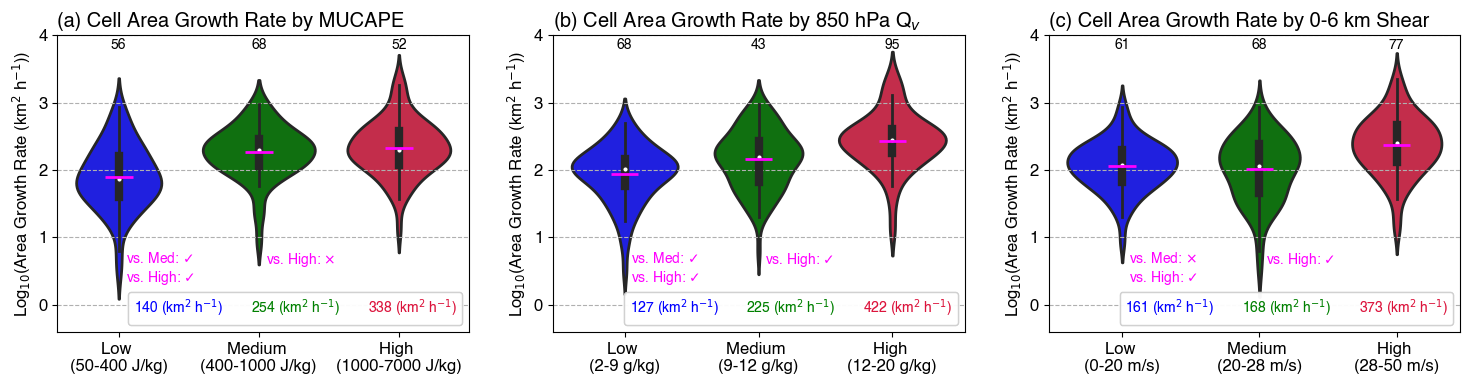

In [192]:
data1 = [gr1_cape1, gr1_cape2, gr1_cape3]
data2 = [gr1_q850p1, gr1_q850p2, gr1_q850p3]
data3 = [gr1_shear6mag1, gr1_shear6mag2, gr1_shear6mag3]
xlabels1 = [f'Low \n({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)',
           f'Medium \n({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)',
           f'High \n({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)',]
xlabels2 = [f'Low \n({q850p_gr_range1[0]}-{q850p_gr_range1[1]} g/kg)',
            f'Medium \n({q850p_gr_range2[0]}-{q850p_gr_range2[1]} g/kg)',
            f'High \n({q850p_gr_range3[0]}-{q850p_gr_range3[1]} g/kg)']
xlabels3 = [f'Low \n({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]} m/s)',
            f'Medium \n({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]} m/s)',
            f'High \n({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]} m/s)']
# sigtest = {'cape_low':'vs. Med: '+sig1_cape12+'\n'+'vs. High: '+sig1_cape13,
#            'cape_med':'vs. High: '+sig1_cape23,
#            'q850p_low':'vs. Med: '+sig1_q850p12+'\n'+'vs. High: '+sig1_q850p13,
#            'q850p_med':'vs. High: '+sig1_q850p13,
#            'shear6mag_low':'vs. Med: '+sig1_shear6mag12+'\n'+'vs. High: '+sig1_shear6mag13,
#            'shear6mag_med':'vs. High: '+sig1_shear6mag23,}
sigtest = {'cape_low':'vs. Med: '+KSsig1_cape12+'\n'+'vs. High: '+KSsig1_cape13,
           'cape_med':'vs. High: '+KSsig1_cape23,
           'q850p_low':'vs. Med: '+KSsig1_q850p12+'\n'+'vs. High: '+KSsig1_q850p13,
           'q850p_med':'vs. High: '+KSsig1_q850p13,
           'shear6mag_low':'vs. Med: '+KSsig1_shear6mag12+'\n'+'vs. High: '+KSsig1_shear6mag13,
           'shear6mag_med':'vs. High: '+KSsig1_shear6mag23,}
ns1 = [ns_gr1_cape1, ns_gr1_cape2, ns_gr1_cape3]
ns2 = [ns_gr1_q850p1, ns_gr1_q850p2, ns_gr1_q850p3]
ns3 = [ns_gr1_shear6mag1, ns_gr1_shear6mag2, ns_gr1_shear6mag3]
ylabel = 'Log$_{10}$(Area Growth Rate (km$^2$ h$^{-1}$))'
ylim = (-0.4, 4)
titles = ['(a) Cell Area Growth Rate by MUCAPE',
          '(b) Cell Area Growth Rate by 850 hPa Q$_v$',
          '(c) Cell Area Growth Rate by 0-6 km Shear']
figname = f'{figdir}cellarea_growthrate_violin_MUCAPE_qv850mb_shear6km_method1.png'
fig = plot_3violin(data1, data2, data3, ns1, ns2, ns3, xlabels1, xlabels2, xlabels3, ylabel, ylim, titles, figname, sigtest=sigtest)

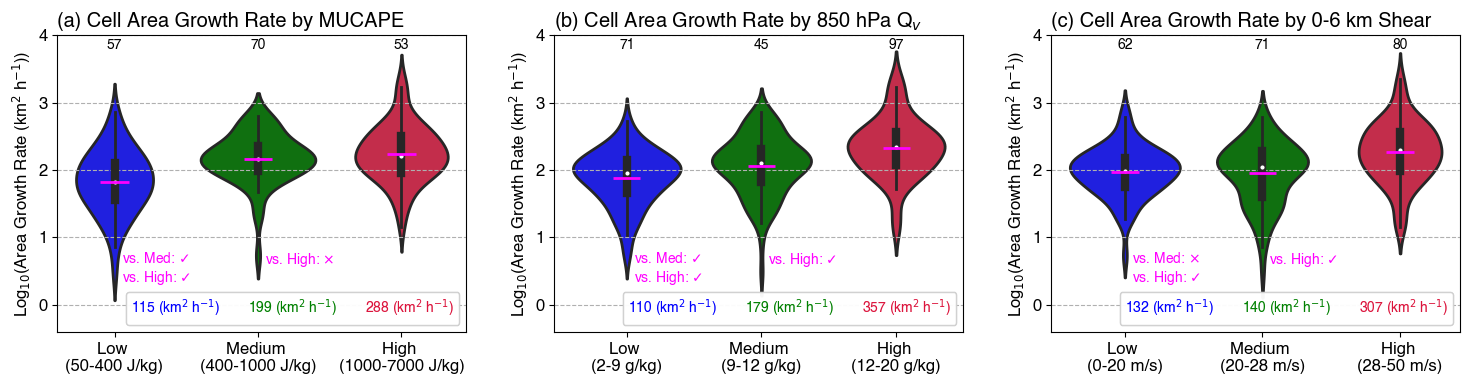

In [193]:
data1 = [gr2_cape1, gr2_cape2, gr2_cape3]
data2 = [gr2_q850p1, gr2_q850p2, gr2_q850p3]
data3 = [gr2_shear6mag1, gr2_shear6mag2, gr2_shear6mag3]
xlabels1 = [f'Low \n({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)',
           f'Medium \n({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)',
           f'High \n({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)',]
xlabels2 = [f'Low \n({q850p_gr_range1[0]}-{q850p_gr_range1[1]} g/kg)',
            f'Medium \n({q850p_gr_range2[0]}-{q850p_gr_range2[1]} g/kg)',
            f'High \n({q850p_gr_range3[0]}-{q850p_gr_range3[1]} g/kg)']
xlabels3 = [f'Low \n({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]} m/s)',
            f'Medium \n({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]} m/s)',
            f'High \n({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]} m/s)']
# sigtest = {'cape_low':'vs. Med: '+sig2_cape12+'\n'+'vs. High: '+sig2_cape13,
#            'cape_med':'vs. High: '+sig2_cape23,
#            'q850p_low':'vs. Med: '+sig2_q850p12+'\n'+'vs. High: '+sig2_q850p13,
#            'q850p_med':'vs. High: '+sig2_q850p13,
#            'shear6mag_low':'vs. Med: '+sig2_shear6mag12+'\n'+'vs. High: '+sig2_shear6mag13,
#            'shear6mag_med':'vs. High: '+sig2_shear6mag23,}
sigtest = {'cape_low':'vs. Med: '+KSsig2_cape12+'\n'+'vs. High: '+KSsig2_cape13,
           'cape_med':'vs. High: '+KSsig2_cape23,
           'q850p_low':'vs. Med: '+KSsig2_q850p12+'\n'+'vs. High: '+KSsig2_q850p13,
           'q850p_med':'vs. High: '+KSsig2_q850p13,
           'shear6mag_low':'vs. Med: '+KSsig2_shear6mag12+'\n'+'vs. High: '+KSsig2_shear6mag13,
           'shear6mag_med':'vs. High: '+KSsig2_shear6mag23,}
ns1 = [ns_gr2_cape1, ns_gr2_cape2, ns_gr2_cape3]
ns2 = [ns_gr2_q850p1, ns_gr2_q850p2, ns_gr2_q850p3]
ns3 = [ns_gr2_shear6mag1, ns_gr2_shear6mag2, ns_gr2_shear6mag3]
ylabel = 'Log$_{10}$(Area Growth Rate (km$^2$ h$^{-1}$))'
ylim = (-0.4, 4)
titles = ['(a) Cell Area Growth Rate by MUCAPE',
          '(b) Cell Area Growth Rate by 850 hPa Q$_v$',
          '(c) Cell Area Growth Rate by 0-6 km Shear']
figname = f'{figdir}cellarea_growthrate_violin_MUCAPE_qv850mb_shear6km_method2.png'
fig = plot_3violin(data1, data2, data3, ns1, ns2, ns3, xlabels1, xlabels2, xlabels3, ylabel, ylim, titles, figname, sigtest=sigtest)

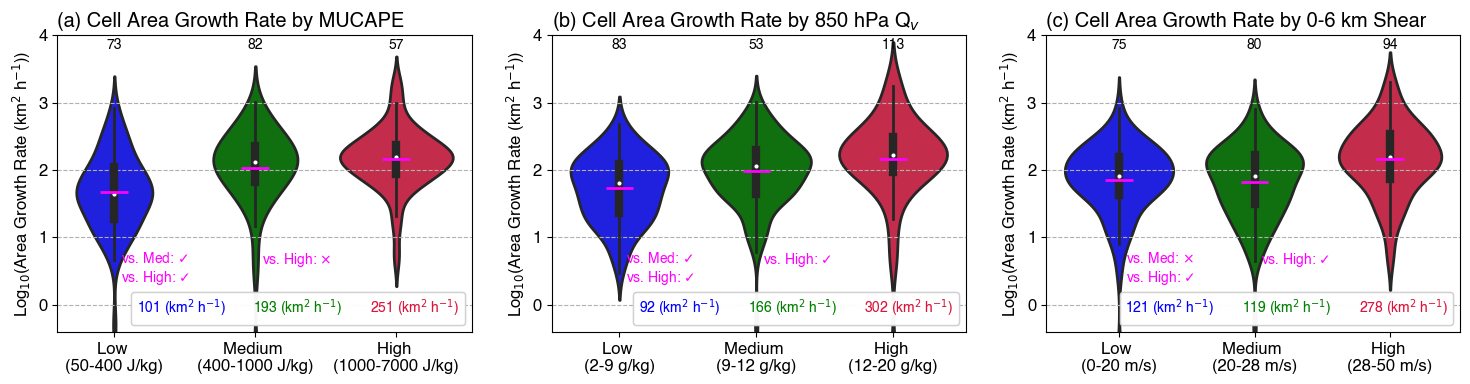

In [196]:
data1 = [gr3_cape1, gr3_cape2, gr3_cape3]
data2 = [gr3_q850p1, gr3_q850p2, gr3_q850p3]
data3 = [gr3_shear6mag1, gr3_shear6mag2, gr3_shear6mag3]
xlabels1 = [f'Low \n({cape_gr_range1[0]}-{cape_gr_range1[1]} J/kg)',
           f'Medium \n({cape_gr_range2[0]}-{cape_gr_range2[1]} J/kg)',
           f'High \n({cape_gr_range3[0]}-{cape_gr_range3[1]} J/kg)',]
xlabels2 = [f'Low \n({q850p_gr_range1[0]}-{q850p_gr_range1[1]} g/kg)',
            f'Medium \n({q850p_gr_range2[0]}-{q850p_gr_range2[1]} g/kg)',
            f'High \n({q850p_gr_range3[0]}-{q850p_gr_range3[1]} g/kg)']
xlabels3 = [f'Low \n({shear6mag_gr_range1[0]}-{shear6mag_gr_range1[1]} m/s)',
            f'Medium \n({shear6mag_gr_range2[0]}-{shear6mag_gr_range2[1]} m/s)',
            f'High \n({shear6mag_gr_range3[0]}-{shear6mag_gr_range3[1]} m/s)']
# sigtest = {'cape_low':'vs. Med: '+sig3_cape12+'\n'+'vs. High: '+sig3_cape13,
#            'cape_med':'vs. High: '+sig3_cape23,
#            'q850p_low':'vs. Med: '+sig3_q850p12+'\n'+'vs. High: '+sig3_q850p13,
#            'q850p_med':'vs. High: '+sig3_q850p13,
#            'shear6mag_low':'vs. Med: '+sig3_shear6mag12+'\n'+'vs. High: '+sig3_shear6mag13,
#            'shear6mag_med':'vs. High: '+sig3_shear6mag23,}
sigtest = {'cape_low':'vs. Med: '+KSsig3_cape12+'\n'+'vs. High: '+KSsig3_cape13,
           'cape_med':'vs. High: '+KSsig3_cape23,
           'q850p_low':'vs. Med: '+KSsig3_q850p12+'\n'+'vs. High: '+KSsig3_q850p13,
           'q850p_med':'vs. High: '+KSsig3_q850p13,
           'shear6mag_low':'vs. Med: '+KSsig3_shear6mag12+'\n'+'vs. High: '+KSsig3_shear6mag13,
           'shear6mag_med':'vs. High: '+KSsig3_shear6mag23,}
ns1 = [ns_gr3_cape1, ns_gr3_cape2, ns_gr3_cape3]
ns2 = [ns_gr3_q850p1, ns_gr3_q850p2, ns_gr3_q850p3]
ns3 = [ns_gr3_shear6mag1, ns_gr3_shear6mag2, ns_gr3_shear6mag3]
ylabel = 'Log$_{10}$(Area Growth Rate (km$^2$ h$^{-1}$))'
ylim = (-0.4, 4)
titles = ['(a) Cell Area Growth Rate by MUCAPE',
          '(b) Cell Area Growth Rate by 850 hPa Q$_v$',
          '(c) Cell Area Growth Rate by 0-6 km Shear']
# figname = f'{figdir}cellarea_growthrate_violin_MUCAPE_qv850mb_shear6km_method3.png'
figname = f'{figdir}cellarea_growthrate_violin_MUCAPE_qv850mb_shear6km_method3.pdf'
fig = plot_3violin(data1, data2, data3, ns1, ns2, ns3, xlabels1, xlabels2, xlabels3, ylabel, ylim, titles, figname, sigtest=sigtest)

In [88]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'

In [55]:
def quantiles_by2cond(in_var, cond1_var, cond1_range, cond2_var, cond2_range, loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles, fillval=-99):
    in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                                (cond1_var >= cond1_range[0]) & (cond1_var <= cond1_range[1]) & 
                                (cond2_var >= cond2_range[0]) & (cond2_var <= cond2_range[1]) & 
                                (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)

    nsamples = in_var_cond.sizes['tracks']
    
    # Replace NaN with a large negative value to take into account decreasing sample with height
    # NaN is excluded in quantile calculations which biases the sampling with increasing height
#     fillval = -99
    in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
    
    # Get time-series quantile
    out_var_cond_pts = in_var_cond.quantile(quantiles, dim='tracks', skipna=True)

#     # Calculate initiation quantiles
#     out_var_time0_pts = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True)
#     # Calculate max during lifetime quantiles
#     out_var_max_pts = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True)
    
    return (nsamples, out_var_cond_pts)

In [56]:
# lifetime_range1 = [0.4,0.5]
# lifetime_range2 = [0.9,1]
# lifetime_range1 = [1.7,2.1]
# lifetime_range2 = [1.7,2.1]
# lifetime_range3 = [1.7,2.1]
lifetime_range1 = [1.75,2.0]
lifetime_range2 = [1.75,2.0]
lifetime_range3 = [1.75,2.0]
quantiles_timeseries = [0.5,0.9]

fillval_dbz = 0
fillval_dbzarea = 0
fillval_kdp = -99
fillval_zdr = -99
fillval_rr = 0
fillval_Dm = 0
fillval_rainvol = 0

# Max reflectivity profile
ntracks1_capelifetime, max_dbz1_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks2_capelifetime, max_dbz2_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks3_capelifetime, max_dbz3_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
print(ntracks1_capelifetime, ntracks2_capelifetime, ntracks3_capelifetime)

# 20 dBZ area profile
ntracks1_capelifetime, dbz20_area1_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_capelifetime, dbz20_area2_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_capelifetime, dbz20_area3_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# 30dBZ area profile
ntracks1_capelifetime, dbz30_area1_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_capelifetime, dbz30_area2_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_capelifetime, dbz30_area3_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# Max KDP profile
ntracks1_capelifetime, max_kdp1_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks2_capelifetime, max_kdp2_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks3_capelifetime, max_kdp3_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
# Max ZDR profile
ntracks1_capelifetime, max_zdr1_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks2_capelifetime, max_zdr2_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks3_capelifetime, max_zdr3_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
# Max rainrate profile
ntracks1_capelifetime, max_rainrate1_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks2_capelifetime, max_rainrate2_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks3_capelifetime, max_rainrate3_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
# Max Dm profile
ntracks1_capelifetime, max_Dm1_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks2_capelifetime, max_Dm2_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks3_capelifetime, max_Dm3_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
# Max vol. rain profile
ntracks1_capelifetime, volrain1_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks2_capelifetime, volrain2_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks3_capelifetime, volrain3_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)

39 28 26


In [57]:
# Max reflectivity profile
ntracks1_q850plifetime, max_dbz1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks2_q850plifetime, max_dbz2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks3_q850plifetime, max_dbz3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
print(ntracks1_q850plifetime, ntracks2_q850plifetime, ntracks3_q850plifetime)

# 20 dBZ area profile
ntracks1_q850plifetime, dbz20_area1_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_q850plifetime, dbz20_area2_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_q850plifetime, dbz20_area3_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# 30dBZ area profile
ntracks1_q850plifetime, dbz30_area1_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_q850plifetime, dbz30_area2_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_q850plifetime, dbz30_area3_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# Max KDP profile
ntracks1_q850plifetime, max_kdp1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks2_q850plifetime, max_kdp2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks3_q850plifetime, max_kdp3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
# Max ZDR profile
ntracks1_q850plifetime, max_zdr1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks2_q850plifetime, max_zdr2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks3_q850plifetime, max_zdr3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
# Max rainrate profile
ntracks1_q850plifetime, max_rainrate1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks2_q850plifetime, max_rainrate2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks3_q850plifetime, max_rainrate3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
# Max Dm profile
ntracks1_q850plifetime, max_Dm1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks2_q850plifetime, max_Dm2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks3_q850plifetime, max_Dm3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
# Max vol. rain profile
ntracks1_q850plifetime, volrain1_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks2_q850plifetime, volrain2_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks3_q850plifetime, volrain3_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)

26 63 29


In [58]:
# Max reflectivity profile
ntracks1_shear6maglifetime, max_dbz1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks2_shear6maglifetime, max_dbz2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
ntracks3_shear6maglifetime, max_dbz3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbz)
print(ntracks1_shear6maglifetime, ntracks2_shear6maglifetime, ntracks3_shear6maglifetime)

# 20 dBZ area profile
ntracks1_shear6maglifetime, dbz20_area1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_shear6maglifetime, dbz20_area2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_shear6maglifetime, dbz20_area3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# 30dBZ area profile
ntracks1_shear6maglifetime, dbz30_area1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks2_shear6maglifetime, dbz30_area2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
ntracks3_shear6maglifetime, dbz30_area3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_dbzarea)
# Max KDP profile
ntracks1_shear6maglifetime, max_kdp1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks2_shear6maglifetime, max_kdp2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
ntracks3_shear6maglifetime, max_kdp3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_kdp)
# Max ZDR profile
ntracks1_shear6maglifetime, max_zdr1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks2_shear6maglifetime, max_zdr2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
ntracks3_shear6maglifetime, max_zdr3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_zdr)
# Max rainrate profile
ntracks1_shear6maglifetime, max_rainrate1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks2_shear6maglifetime, max_rainrate2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
ntracks3_shear6maglifetime, max_rainrate3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rr)
# Max Dm profile
ntracks1_shear6maglifetime, max_Dm1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks2_shear6maglifetime, max_Dm2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
ntracks3_shear6maglifetime, max_Dm3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_Dm)
# Max vol. rain profile
ntracks1_shear6maglifetime, volrain1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks2_shear6maglifetime, volrain2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)
ntracks3_shear6maglifetime, volrain3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
                                                                         start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries, fillval=fillval_rainvol)

31 51 36


In [59]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'

In [60]:
def plot_timeheight_5vars(times, heights, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabels, cbticks, legend1, legend2, figname, oob_colors=None):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=[12,13], dpi=100)
    gs = gridspec.GridSpec(5,4, height_ratios=[1,1,1,1,1], width_ratios=[1,1,1,0.04])
    gs.update(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.18, hspace=0.15)

    ylabels = ['Height ASL (km)','','']

    pcm_save = []
    for row in range(5):
        cmap = copy.copy(plt.get_cmap(cmaps[row]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[row], ncolors=cmap.N)
        for col in range(3):
            ax1 = plt.subplot(gs[row,col])
            Zm = np.ma.masked_invalid(dataarr[row][col])
            Zm = np.ma.masked_where(Zm <= 0, Zm)
            pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
            if (row == 4):
                ax1.set_xlabel(xlabels)
                ax1.annotate("", xy=(1, -0.25), xycoords='axes fraction', xytext=(0, -0.24), arrowprops=dict(facecolor='black'))
            ax1.set_ylabel(ylabels[col])
            if (row == 0):
                ax1.set_title(titles[col], loc='left', fontsize=16)
                ax1.text(.98, .9, legend2[col], ha='right', transform=ax1.transAxes)
            if (col == 0):
                ax1.text(0.02, 0.9, legend1[row], ha='left', fontsize=14, transform=ax1.transAxes)
            ax1.set_xlim(np.min(xlims), np.max(xlims))
            ax1.set_ylim(np.min(ylims), np.max(ylims))
            ax1.set_xticks(xticks)
            ax1.set_yticks(yticks)
            ax1.grid(ls='--')
            if oob_colors is not None:
                pcm.cmap.set_over(oob_colors[row]['over'])
                pcm.cmap.set_under(oob_colors[row]['under'])
                pcm.set_clim(min(levels[row]), max(levels[row]))
            ax1.fill_between([np.min(xlims), np.max(xlims)], radar_alt, 0, color='darkgray')
        # Save pcolormesh object for plotting colorbar
        pcm_save.append(pcm)

        # Colorbar
        cax = plt.subplot(gs[row,3])
        cbar = plt.colorbar(pcm, cax=cax, label=cblabels[row], extend='both', ticks=cbticks[row])

    fig.savefig(figname, bbox_inches='tight', dpi=300)

In [61]:
def plot_timeheight_Nvars(times, heights, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabels, cbticks, legend1, legend2, figname, 
                          oob_colors=None, figsize=[12,15]):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=figsize, dpi=100)
    nrows = len(dataarr)
    gs = gridspec.GridSpec(nrows,4, height_ratios=np.repeat(1, nrows).tolist(), width_ratios=[1,1,1,0.04])
    gs.update(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.18, hspace=0.15)
    ylabels = ['Height ASL (km)','','']

    pcm_save = []
    for row in range(nrows):
        cmap = copy.copy(plt.get_cmap(cmaps[row]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[row], ncolors=cmap.N)
        for col in range(3):
            ax1 = plt.subplot(gs[row,col])
            Zm = np.ma.masked_invalid(dataarr[row][col])
            Zm = np.ma.masked_where(Zm <= 0, Zm)
            pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
            if (row == nrows-1):
                ax1.set_xlabel(xlabels)
                ax1.annotate("", xy=(1, -0.25), xycoords='axes fraction', xytext=(0, -0.24), arrowprops=dict(facecolor='black'))
            ax1.set_ylabel(ylabels[col])
            if (row == 0):
                ax1.set_title(titles[col], loc='left', fontsize=16)
                ax1.text(.98, .9, legend2[col], ha='right', transform=ax1.transAxes)
            if (col == 0):
                ax1.text(0.02, 0.9, legend1[row], ha='left', fontsize=14, transform=ax1.transAxes)
            ax1.set_xlim(np.min(xlims), np.max(xlims))
            ax1.set_ylim(np.min(ylims), np.max(ylims))
            ax1.set_xticks(xticks)
            ax1.set_yticks(yticks)
            ax1.grid(ls='--')
            if oob_colors is not None:
                pcm.cmap.set_over(oob_colors[row]['over'])
                pcm.cmap.set_under(oob_colors[row]['under'])
                pcm.set_clim(min(levels[row]), max(levels[row]))
            ax1.fill_between([np.min(xlims), np.max(xlims)], radar_alt, 0, color='darkgray')
        # Save pcolormesh object for plotting colorbar
        pcm_save.append(pcm)

        # Colorbar
        cax = plt.subplot(gs[row,3])
        cbar = plt.colorbar(pcm, cax=cax, label=cblabels[row], extend='both', ticks=cbticks[row])

    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

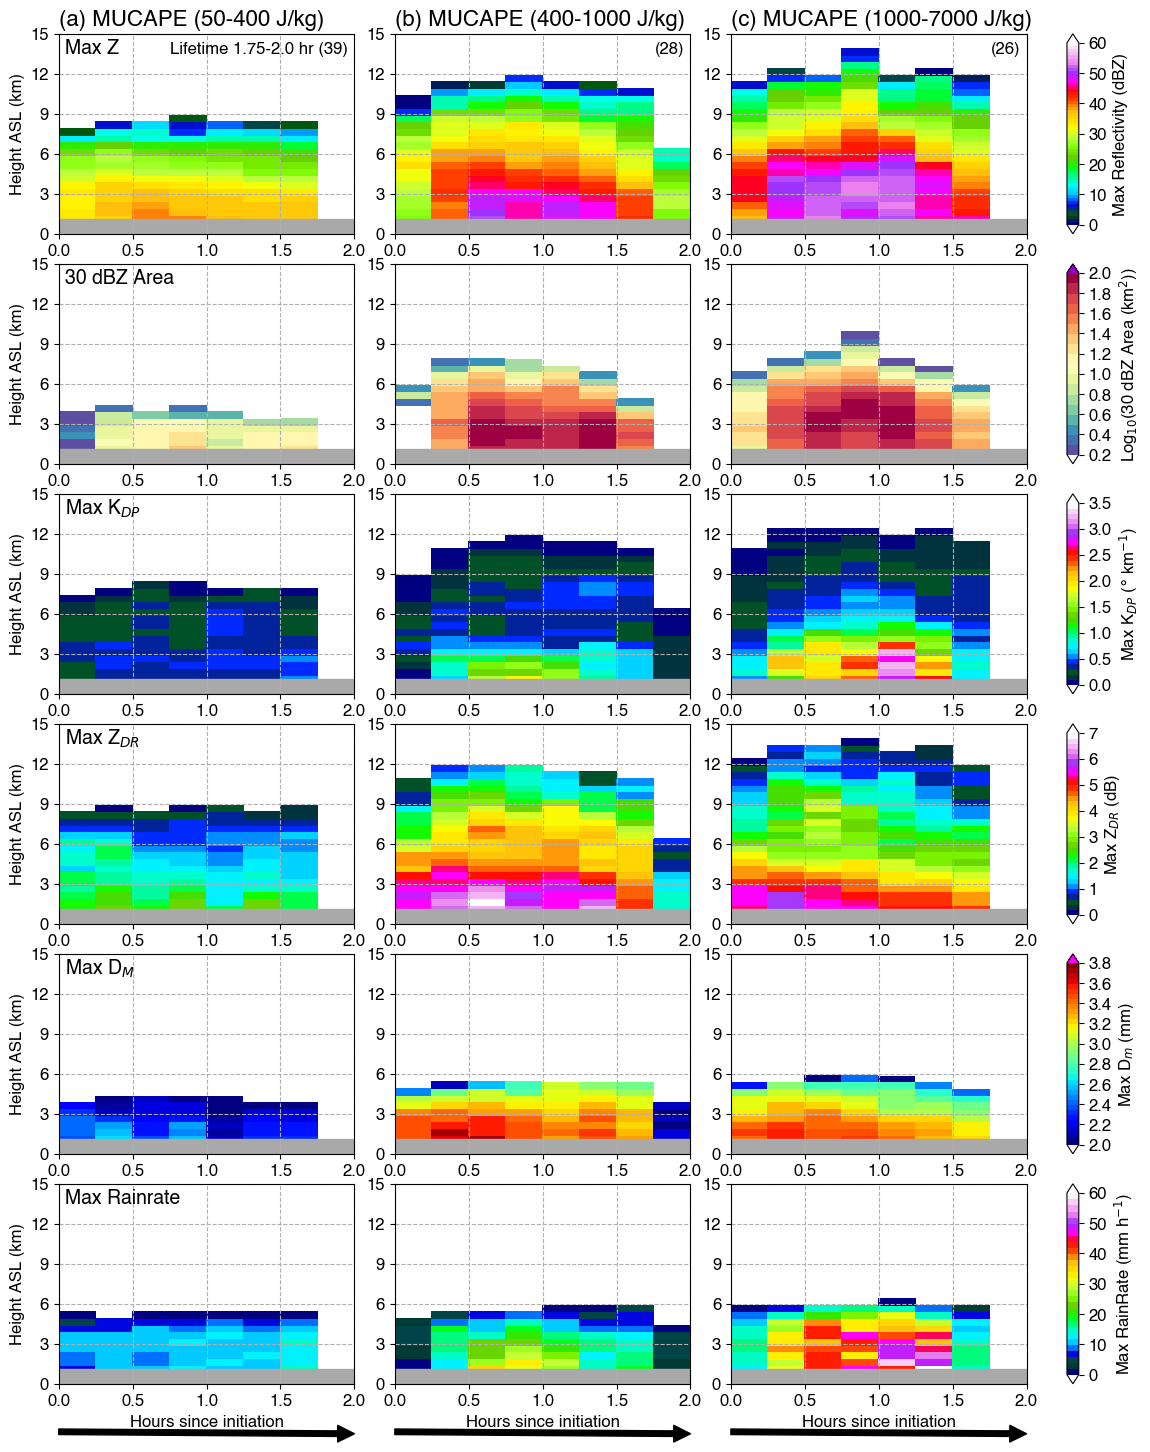

In [122]:
times_hour = times * time_res + time_res/2
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max Z$_{DR}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
          f'({ntracks2_capelifetime})', 
          f'({ntracks3_capelifetime})',]
qntl = 0.5
dataarr = [[max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()], 
#           [np.log10(dbz20_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()],
          [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_zdr1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 60.1, 1), np.arange(0.2, 2.01, 0.1), np.arange(0, 3.51, 0.1), np.arange(0, 7.01, 0.2), np.arange(2, 3.81, 0.05), np.arange(0, 60.1, 2)]
cbticks = [np.arange(0, 60.1, 10), np.arange(0.2, 2.01, 0.2), np.arange(0, 3.51, 0.5), np.arange(0, 7.01, 1), np.arange(2, 3.81, 0.2), np.arange(0, 60.1, 10)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar', 'gist_ncar', 'jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max Z$_{DR}$ (dB)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,15)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,15.1,3)
xlabels = 'Hours since initiation'
titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
          f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
          f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_6variables_{qntl*100:.0f}quantile_MUCAPE.pdf'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,15])

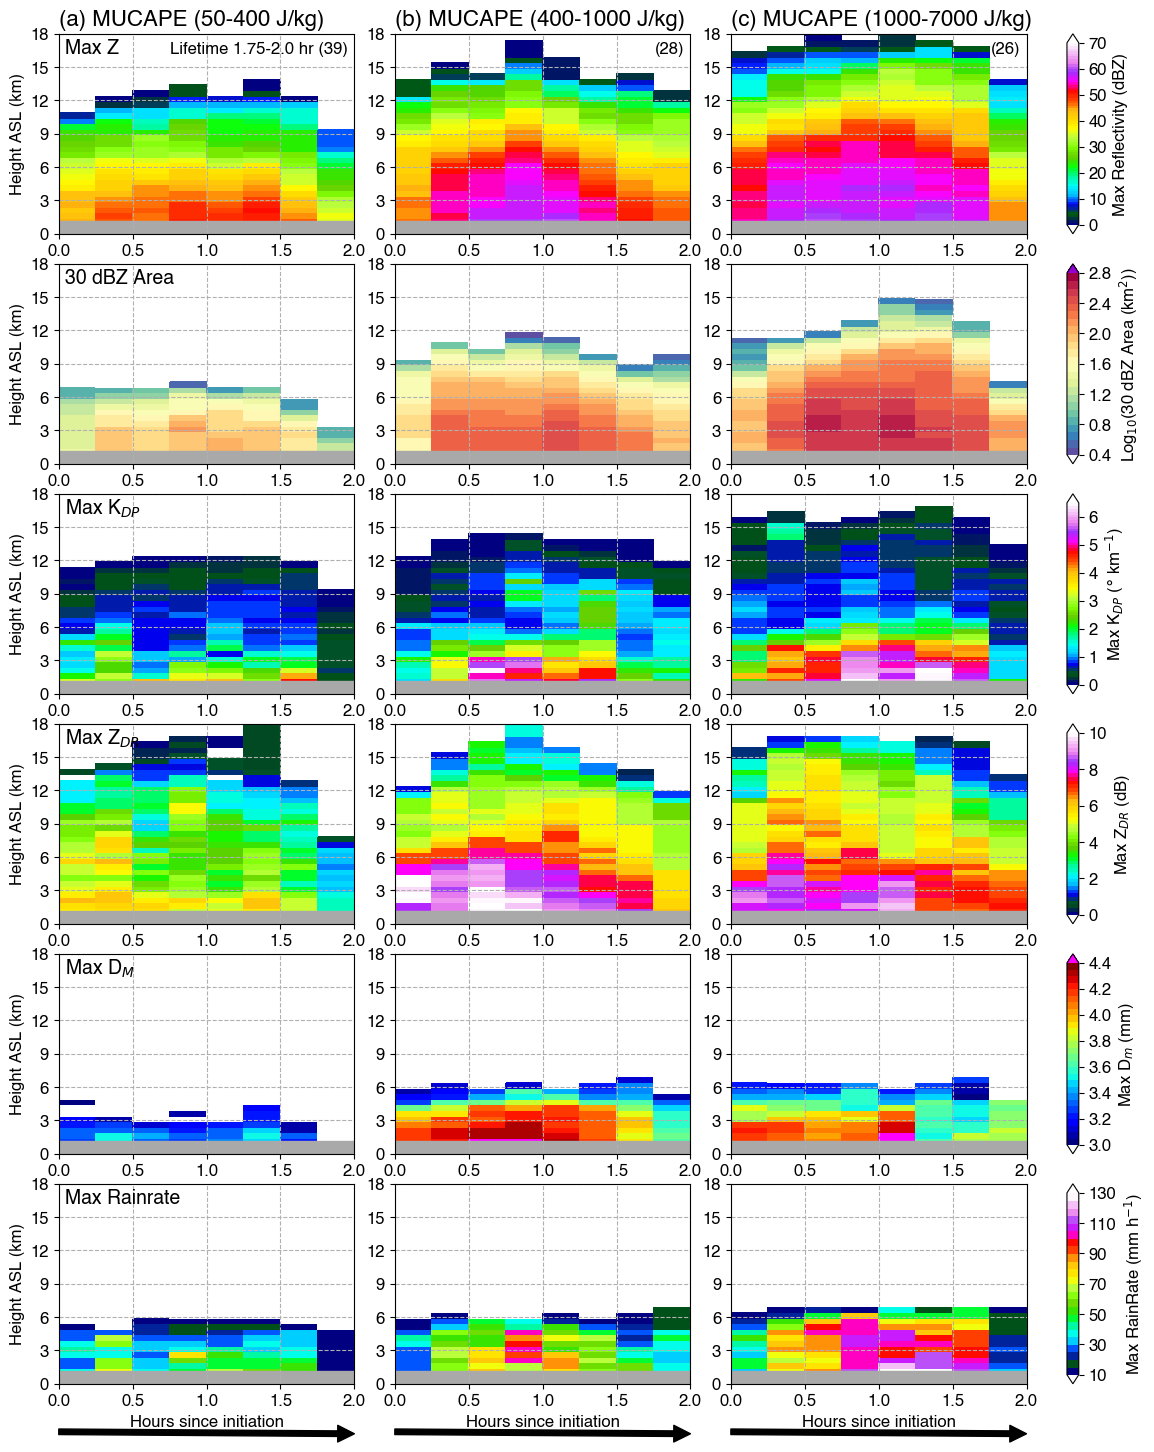

In [93]:
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max Z$_{DR}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
          f'({ntracks2_capelifetime})', 
          f'({ntracks3_capelifetime})',]
qntl = 0.9
dataarr = [[max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()], 
          [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_zdr1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 70.1, 1), np.arange(0.4, 2.81, 0.1), np.arange(0, 6.51, 0.1), np.arange(0, 10.01, 0.2), np.arange(3, 4.41, 0.05), np.arange(10, 130.1, 5)]
cbticks = [np.arange(0, 70.1, 10), np.arange(0.4, 2.81, 0.4), np.arange(0, 6.51, 1), np.arange(0, 10.01, 2), np.arange(3, 4.41, 0.2), np.arange(10, 130.1, 20)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar', 'gist_ncar', 'jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max Z$_{DR}$ (dB)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,18)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,18.1,3)
xlabels = 'Hours since initiation'
titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
          f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
          f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_6variables_{qntl*100:.0f}quantile_MUCAPE.png'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,15])

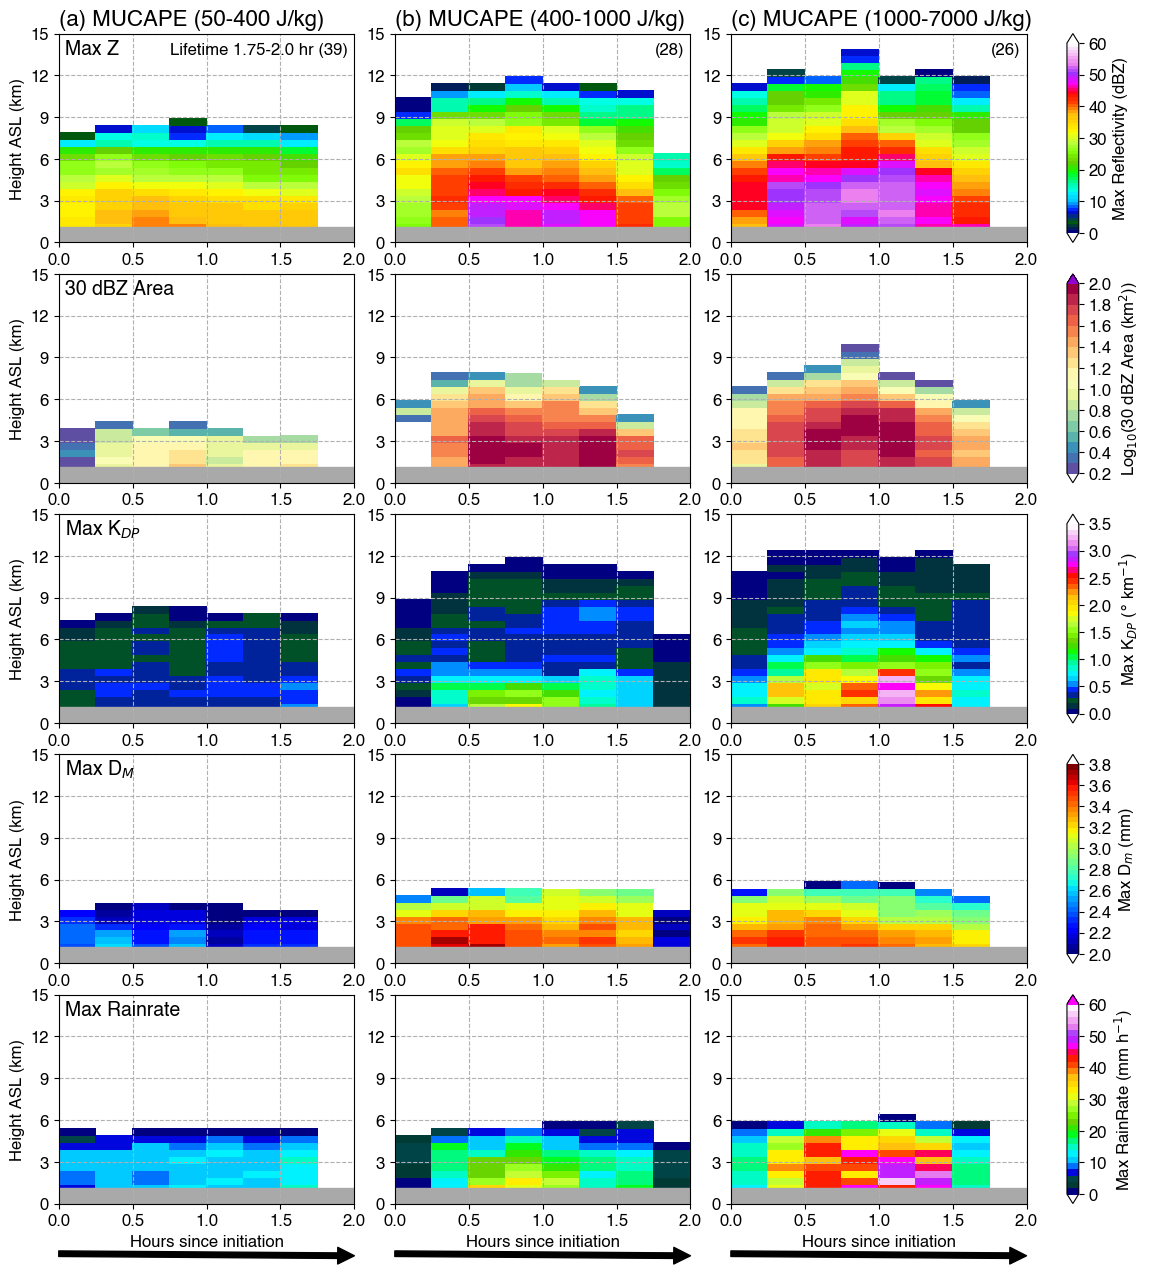

In [94]:
times_hour = times * time_res + time_res/2
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
          f'({ntracks2_capelifetime})', 
          f'({ntracks3_capelifetime})',]
qntl = 0.5
dataarr = [[max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()], 
          [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 60.1, 1), np.arange(0.2, 2.01, 0.1), np.arange(0, 3.51, 0.1), np.arange(2, 3.81, 0.05), np.arange(0, 60.1, 2)]
cbticks = [np.arange(0, 60.1, 10), np.arange(0.2, 2.01, 0.2), np.arange(0, 3.51, 0.5), np.arange(2, 3.81, 0.2), np.arange(0, 60.1, 10)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar','jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,15)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,15.1,3)
xlabels = 'Hours since initiation'
titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
          f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
          f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_5variables_{qntl*100:.0f}quantile_MUCAPE.png'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,13])

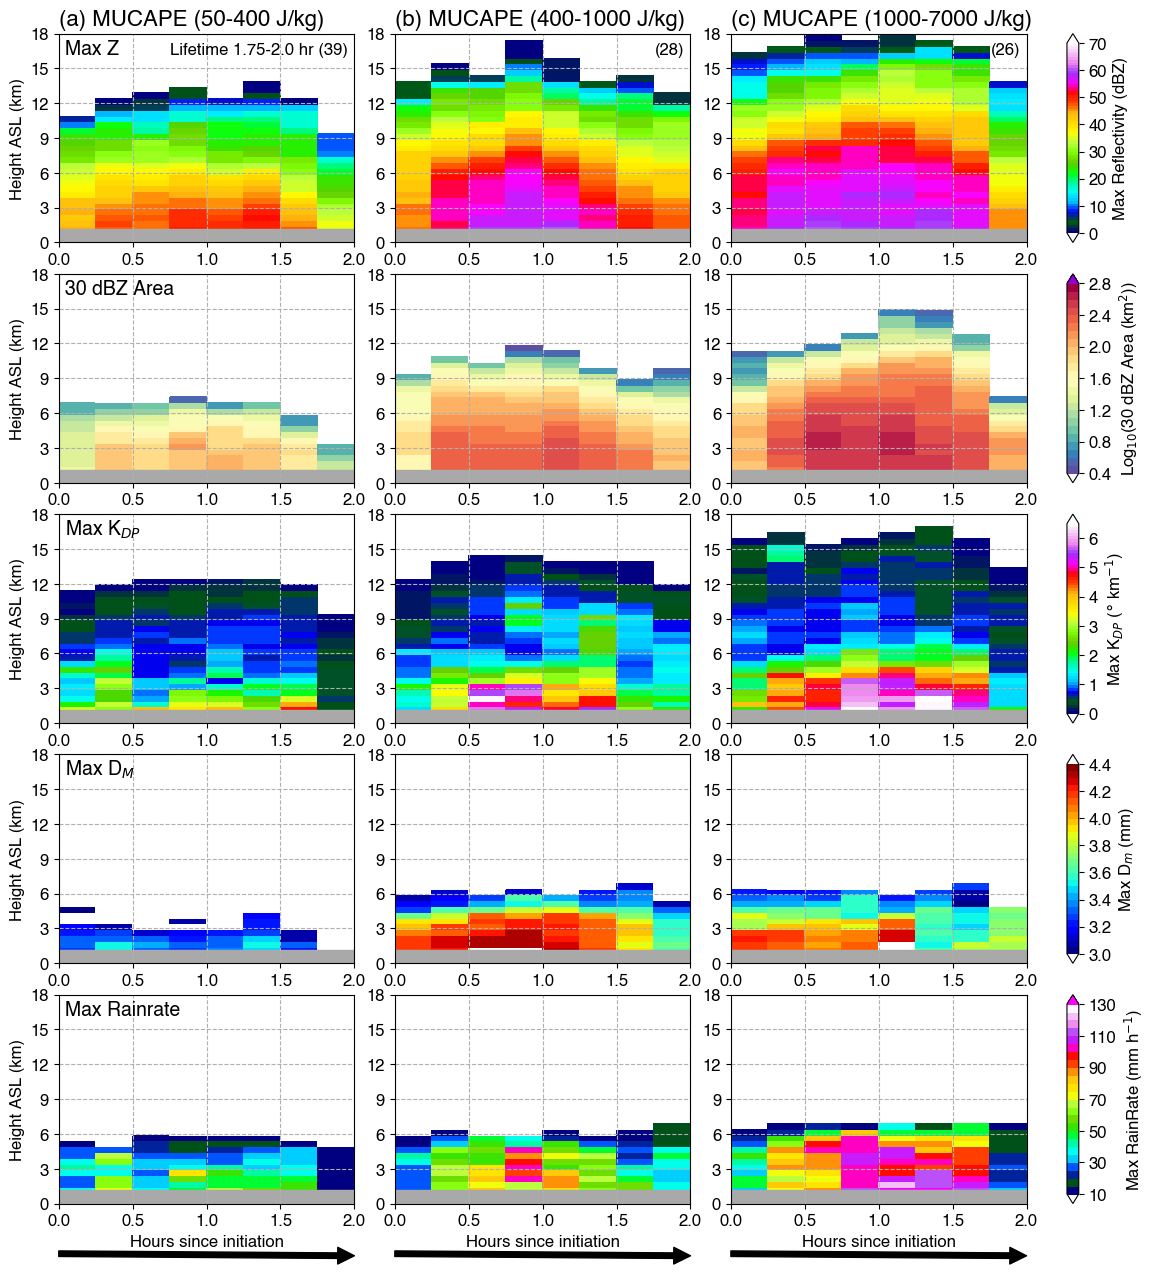

In [95]:
times_hour = times * time_res + time_res/2
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
          f'({ntracks2_capelifetime})', 
          f'({ntracks3_capelifetime})',]
qntl = 0.9
dataarr = [[max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()], 
          [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 70.1, 1), np.arange(0.4, 2.81, 0.1), np.arange(0, 6.51, 0.1), np.arange(3, 4.41, 0.05), np.arange(10, 130.1, 5)]
cbticks = [np.arange(0, 70.1, 10), np.arange(0.4, 2.81, 0.4), np.arange(0, 6.51, 1),  np.arange(3, 4.41, 0.2), np.arange(10, 130.1, 20)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar', 'jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,18)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,18.1,3)
xlabels = 'Hours since initiation'
titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
          f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
          f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_5variables_{qntl*100:.0f}quantile_MUCAPE.png'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,13])

In [96]:
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/celltrack_composite_profile_evolution_5variables_90quantile_MUCAPE.png'

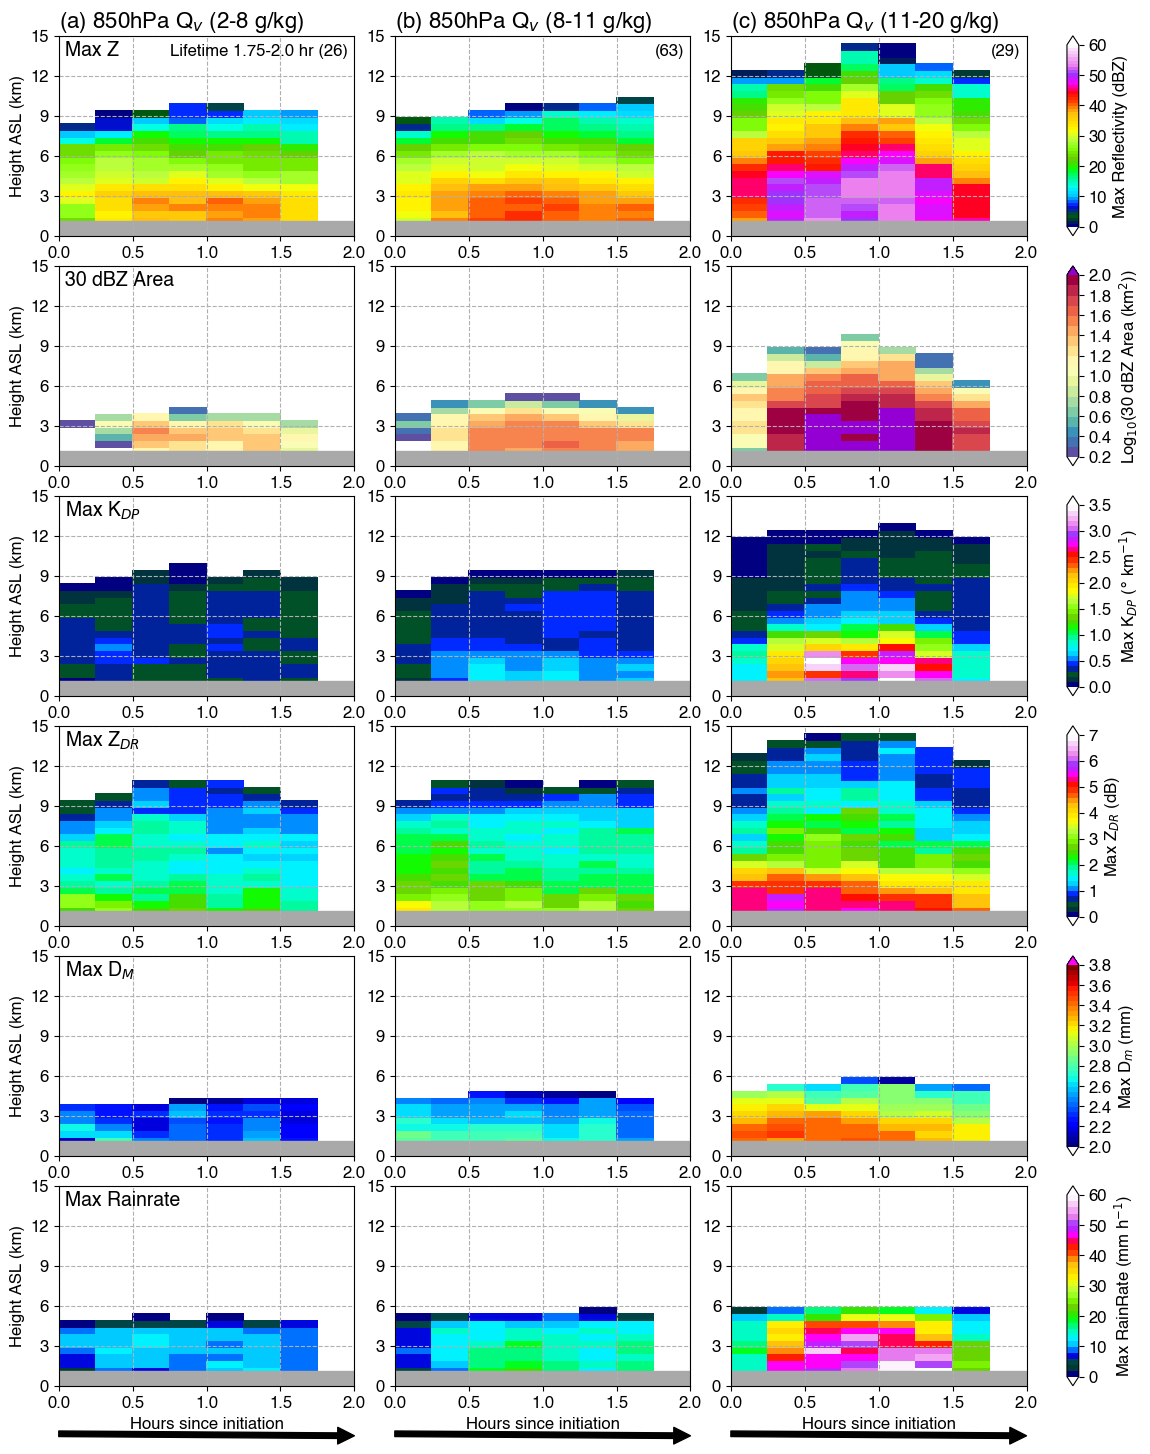

In [97]:
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max Z$_{DR}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_q850plifetime})', 
          f'({ntracks2_q850plifetime})', 
          f'({ntracks3_q850plifetime})',]
qntl = 0.5
dataarr = [[max_dbz1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()], 
          [np.log10(dbz30_area1_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_q850plifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],
          [max_zdr1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],          
          [max_Dm1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 60.1, 1), np.arange(0.2, 2.01, 0.1), np.arange(0, 3.51, 0.1), np.arange(0, 7.01, 0.2), np.arange(2, 3.81, 0.05), np.arange(0, 60.1, 2)]
cbticks = [np.arange(0, 60.1, 10), np.arange(0.2, 2.01, 0.2), np.arange(0, 3.51, 0.5), np.arange(0, 7.01, 1), np.arange(2, 3.81, 0.2), np.arange(0, 60.1, 10)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar', 'gist_ncar', 'jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max Z$_{DR}$ (dB)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,15)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,15.1,3)
xlabels = 'Hours since initiation'

titles = [f'(a) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]}'+' g/kg)', 
          f'(b) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]}'+' g/kg)', 
          f'(c) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]}'+' g/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_6variables_{qntl*100:.0f}quantile_q850hPa.png'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,15])

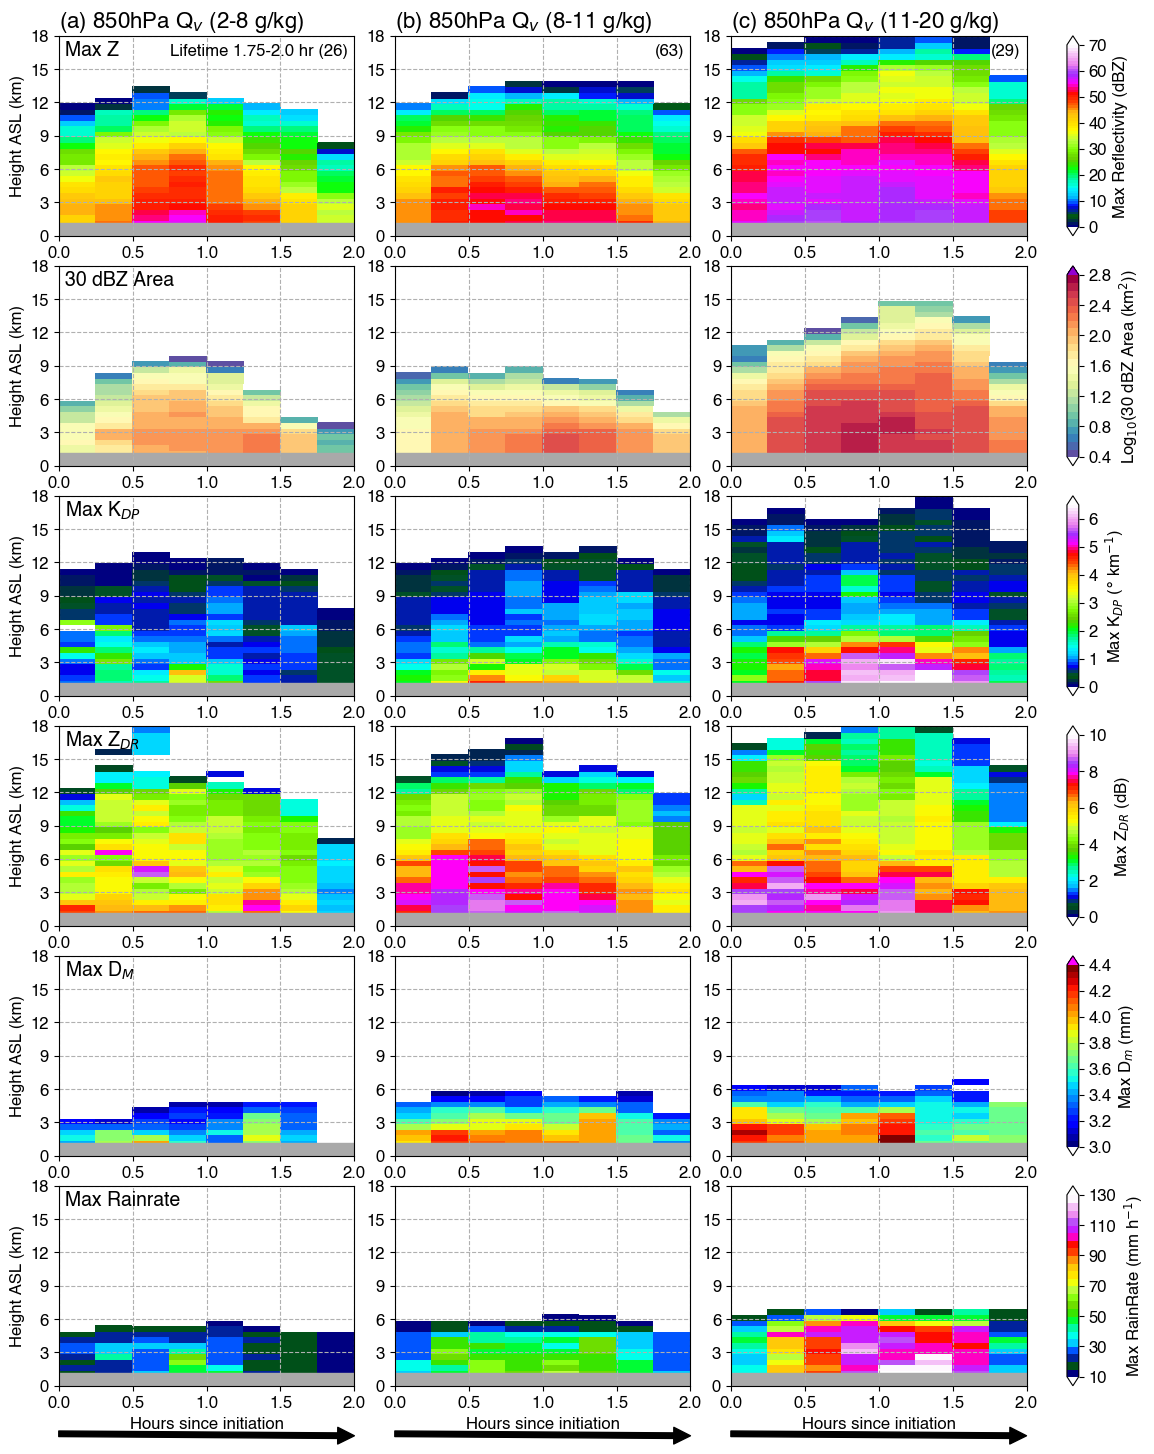

In [98]:
legend1 = ['Max Z', '30 dBZ Area', 'Max K$_{DP}$', 'Max Z$_{DR}$', 'Max D$_M$', 'Max Rainrate']
legend2 = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_q850plifetime})', 
          f'({ntracks2_q850plifetime})', 
          f'({ntracks3_q850plifetime})',]
qntl = 0.9
dataarr = [[max_dbz1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_dbz3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()], 
          [np.log10(dbz30_area1_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area2_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
           np.log10(dbz30_area3_prof_q850plifetime_pts).sel(quantile=qntl).transpose()],
          [max_kdp1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_kdp3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],
          [max_zdr1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_zdr3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],          
          [max_Dm1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_Dm3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()],
          [max_rainrate1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
           max_rainrate3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]]
levels = [np.arange(0, 70.1, 1), np.arange(0.4, 2.81, 0.1), np.arange(0, 6.51, 0.1), np.arange(0, 10.01, 0.2), np.arange(3, 4.41, 0.05), np.arange(10, 130.1, 5)]
cbticks = [np.arange(0, 70.1, 10), np.arange(0.4, 2.81, 0.4), np.arange(0, 6.51, 1), np.arange(0, 10.01, 2), np.arange(3, 4.41, 0.2), np.arange(10, 130.1, 20)]
cmaps = ['gist_ncar', 'Spectral_r', 'gist_ncar', 'gist_ncar', 'jet', 'gist_ncar']
cblabel = ['Max Reflectivity (dBZ)', 'Log$_{10}$(30 dBZ Area (km$^2$))', 'Max K$_{DP}$ ($\degree$ km$^{-1}$)', 'Max Z$_{DR}$ (dB)', 'Max D$_m$ (mm)', 'Max RainRate (mm h$^{-1}$)']
xlims = (0,2.0)
ylims = (0,18)
xticks = np.arange(0, 2.1, 0.5)
yticks = np.arange(0,18.1,3)
xlabels = 'Hours since initiation'

titles = [f'(a) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]}'+' g/kg)', 
          f'(b) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]}'+' g/kg)', 
          f'(c) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]}'+' g/kg)']
figname = f'{figdir}celltrack_composite_profile_evolution_6variables_{qntl*100:.0f}quantile_q850hPa.png'
oob_colors = [{'over':'white', 'under':'white'}, {'over':'darkviolet', 'under':'white'}, {'over':'white', 'under':'white'},
              {'over':'white', 'under':'white'}, {'over':'magenta', 'under':'white'}, {'over':'white', 'under':'white'}]
fig = plot_timeheight_Nvars(times_hour, height+radar_alt, dataarr, levels, cmaps, xlims, ylims, xlabels, xticks, yticks, titles, cblabel, cbticks, legend1, legend2, figname, 
                            oob_colors=oob_colors, figsize=[12,15])

In [99]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'

In [100]:
def plot_timeheight_3panel(times, heights, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, quantile, legend, figname, oob_colors=None):

    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
#     fig, axs = plt.subplots(1, 3, figsize=[15,4], dpi=100)

    fig = plt.figure(figsize=[15,3], dpi=100)
    gs = gridspec.GridSpec(1,4, height_ratios=[1], width_ratios=[1,1,1,0.04])
    gs.update(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.15, hspace=0.08)

    cmap = copy.copy(plt.get_cmap(cmap))
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
#     xlabels = 'Hour since initiation'
    ylabels = ['Height ASL (km)','','']

    pcm_save = []
    for col in range(3):
#         ax1 = axs[col]
        ax1 = plt.subplot(gs[col])
        Zm = np.ma.masked_invalid(dataarr[col])
        Zm = np.ma.masked_where(Zm <= 0, Zm)
        pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels)
        ax1.set_ylabel(ylabels[col])
        ax1.set_title(titles[col], loc='left', fontsize=16)
#         ax1.set_title(f'{quantile:.0f}'+'$^{th}$ percentile', loc='right', fontsize=12)
        ax1.set_xlim(np.min(xlims), np.max(xlims))
        ax1.set_ylim(np.min(ylims), np.max(ylims))
        ax1.set_yticks(yticks)
        ax1.grid(ls='--')
        ax1.text(0.02, 0.9, f'{quantile:.0f}'+'$^{th}$', ha='left', transform=ax1.transAxes)
        ax1.text(.98, .9, legend[col], ha='right', transform=ax1.transAxes)
        if oob_colors is not None:
            pcm.cmap.set_over(oob_colors['over'])
            pcm.cmap.set_under(oob_colors['under'])
            pcm.set_clim(min(levels), max(levels))
        ax1.fill_between([np.min(xlims), np.max(xlims)], radar_alt, 0, color='darkgray')
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

    # Adjust the layout before plotting colorbar
#     fig.tight_layout()

    # Colorbar
#     cbar = fig.colorbar(pcm_save[0], ax=axs[:], shrink=1, pad=0.02, label=cblabel, extend='both')
    cax = plt.subplot(gs[3])
    cbar = fig.colorbar(pcm, cax=cax, label=cblabel, extend='both', ticks=cbticks)
#     cbar.set_ticks(cbticks)

    fig.savefig(figname, bbox_inches='tight', dpi=300)

In [101]:
# # legend = [f'E.SDC ({ntracks1_capelifetime})', f'E.SDC ({ntracks2_capelifetime})', f'E.SDC ({ntracks3_capelifetime})',]
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_capelifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_capelifetime})',]
# qntl = 0.9
# dataarr = [max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 70.1, 1)
# cbticks = np.arange(0, 70.1, 10)
# # levels = np.arange(0, 60.1, 1)
# # cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# xlims = (0,2.0)
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# xlabels = ''
# titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
#           f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
#           f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [102]:
# qntl = 0.9
# dataarr = [np.log10(dbz20_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(1., 3.01, 0.1)
# cbticks = np.arange(1., 3.01, 0.4)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(20 dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area20dbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [103]:
# qntl = 0.9
# dataarr = [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(1., 2.81, 0.1)
# cbticks = np.arange(1., 2.81, 0.2)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [104]:
# qntl = 0.9
# dataarr = [max_zdr1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 20.1, 0.1)
# # cbticks = np.arange(1, 20.1, 2)
# levels = np.arange(1, 10.1, 0.1)
# cbticks = np.arange(1, 10.1, 1)
# # levels = np.arange(0, 6.1, 0.05)
# # cbticks = np.arange(0, 6.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [105]:
# qntl = 0.9
# dataarr = [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 6.51, 0.1)
# cbticks = np.arange(0, 6.51, 1)
# # levels = np.arange(0, 4.01, 0.1)
# # cbticks = np.arange(0, 4.01, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [106]:
# qntl = 0.9
# dataarr = [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(10, 140.1, 5)
# cbticks = np.arange(10, 140.1, 20)
# # levels = np.arange(0, 100.1, 2)
# # cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [107]:
# qntl = 0.9
# dataarr = [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(3, 4.41, 0.05)
# cbticks = np.arange(3, 4.41, 0.2)
# # levels = np.arange(2, 3.81, 0.05)
# # cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'magenta', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [108]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'

In [109]:
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_q850plifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_q850plifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_q850plifetime})',]
# qntl = 0.9
# dataarr = [max_dbz1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 60.1, 1)
# cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# xlims = (0,2.0)
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# xlabels = ''
# titles = [f'(a) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(b) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(c) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [110]:
# qntl = 0.9
# dataarr = [np.log10(dbz30_area1_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_q850plifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.81, 0.1)
# cbticks = np.arange(0.8, 2.81, 0.4)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# xlabels = ''
# titles = [f'(d) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(e) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(f) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [111]:
# qntl = 0.5
# dataarr = [max_zdr1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 10.1, 0.1)
# # cbticks = np.arange(1, 10.1, 1)
# levels = np.arange(0, 6.1, 0.05)
# cbticks = np.arange(0, 6.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# xlabels = ''
# titles = [f'(d) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(e) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(f) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [112]:
# qntl = 0.9
# dataarr = [max_kdp1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 6.51, 0.1)
# cbticks = np.arange(0, 6.51, 1)
# # levels = np.arange(0, 4.51, 0.1)
# # cbticks = np.arange(0, 4.51, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# xlabels = ''
# titles = [f'(h) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(i) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(j) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'navy'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [113]:
# qntl = 0.9
# dataarr = [max_Dm1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(3, 4.41, 0.05)
# cbticks = np.arange(3, 4.41, 0.2)
# # levels = np.arange(2, 3.81, 0.05)
# # cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# xlabels = ''
# titles = [f'(k) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(l) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(m) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'magenta', 'under':'navy'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [114]:
# qntl = 0.9
# dataarr = [max_rainrate1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(10, 130.1, 5)
# cbticks = np.arange(10, 130.1, 10)
# # levels = np.arange(0, 100.1, 2)
# # cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# xlabels = 'Hours since initiation'
# titles = [f'(n) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(o) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(p) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'navy'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [115]:
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_shear6maglifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_shear6maglifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_shear6maglifetime})',]
# qntl = 0.5
# dataarr = [max_dbz1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 60.1, 1)
# cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# titles = [f'(a) 0-6km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)', 
#           f'(b) 0-6km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)', 
#           f'(c) 0-6km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [116]:
# qntl = 0.5
# dataarr = [np.log10(dbz30_area1_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.41, 0.1)
# cbticks = np.arange(0.8, 2.41, 0.2)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [117]:
# qntl = 0.5
# dataarr = [max_zdr1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 10.1, 0.1)
# # cbticks = np.arange(1, 10.1, 1)
# levels = np.arange(0, 6.1, 0.05)
# cbticks = np.arange(0, 6.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [118]:
# qntl = 0.5
# dataarr = [max_kdp1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(0, 6.51, 0.1)
# # cbticks = np.arange(0, 6.51, 1)
# levels = np.arange(0, 4.51, 0.1)
# cbticks = np.arange(0, 4.51, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [119]:
# qntl = 0.5
# dataarr = [max_rainrate1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(10, 120.1, 5)
# # cbticks = np.arange(10, 120.1, 10)
# levels = np.arange(0, 100.1, 2)
# cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [120]:
# qntl = 0.5
# dataarr = [max_Dm1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(3, 4.41, 0.05)
# # cbticks = np.arange(3, 4.41, 0.2)
# levels = np.arange(2, 3.81, 0.05)
# cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'magenta', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height+radar_alt, dataarr, levels, cmap, xlims, ylims, xlabels, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [121]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'